<a href="https://colab.research.google.com/github/gpicciuca/ai_engineering_master/blob/main/module3_ml_cross-selling/Progetto_ML_AssurePredict%2C_Cross_selling_di_polizze_assicurative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto per il cross-selling delle polizze assicurative
Corso: Fondamenti di Machine Learning @ Profession.AI <br>
Master in AI Engineering

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, average_precision_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

RNG_SEED = 2

In [ ]:
DATASET_URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv"

df_raw = pd.read_csv(DATASET_URL, index_col=["id"])
df_raw.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# Esplorazione del dataset
Per determinare quali feature usare.<br>
Prima di procedere, però, dobbiamo codificare numericamente le feature categoriche.

In [ ]:
def preprocess_labels(df):
    """
    Codifica le label del dataset
    """

    df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1}) # Categorical
    df["Vehicle_Age"] = df["Vehicle_Age"].map({"< 1 Year": 1, "1-2 Year": 2, "> 2 Years": 3}) # Ordinal
    df["Vehicle_Damage"] = df["Vehicle_Damage"].map({"No": 0, "Yes": 1}) # Categorical
    return df

In [ ]:
df_raw = preprocess_labels(df_raw)
df_raw.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,0,44,1,28.0,0,3,1,40454.0,26.0,217,1
2,0,76,1,3.0,0,2,0,33536.0,26.0,183,0
3,0,47,1,28.0,0,3,1,38294.0,26.0,27,1
4,0,21,1,11.0,1,1,0,28619.0,152.0,203,0
5,1,29,1,41.0,1,1,0,27496.0,152.0,39,0


In [ ]:
df_raw.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,0.459239,38.822584,0.997869,26.388807,0.458210,1.609616,0.504877,30564.389581,112.034295,154.347397,0.122563
std,0.498336,15.511611,0.046110,13.229888,0.498251,0.567439,0.499977,17213.155057,54.203995,83.671304,0.327936
min,0.000000,20.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,0.000000,25.000000,1.000000,15.000000,0.000000,1.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,0.000000,36.000000,1.000000,28.000000,0.000000,2.000000,1.000000,31669.000000,133.000000,154.000000,0.000000
75%,1.000000,49.000000,1.000000,35.000000,1.000000,2.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,1.000000,85.000000,1.000000,52.000000,1.000000,3.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


Qui si nota sin da subito che Annual_Premium ha dei massimi estremamente elevati rispetto alla media e al 75%. Se la usiamo come feature nel nostro modello, andrà ad influenzarne le prestazioni dato che gli outlier sono sostanzialmente del rumore nei dati (dataset noise) che destabilizzano il processo decisionale, sopratutto per un modello lineare come la LogisticRegression.

In [ ]:
def plot_feature_distribution(dataframe):
    """
    Plotta la distribuzione delle feature categoriche e numeriche
    in una griglia con 3 colonne rispetto al target Response.
    """

    num_cols = len(dataframe.columns)
    max_cols = 3
    rows = (num_cols // max_cols) + (num_cols % max_cols > 0)

    fig, axes = plt.subplots(rows, max_cols, figsize=(12, rows * max_cols))
    axes = axes.flatten()

    for i, col in enumerate(dataframe.columns):
        ax = axes[i]
        if dataframe[col].dtype == 'object' or dataframe[col].nunique() < 10:
            sns.countplot(data=dataframe, x=col, ax=ax, palette="viridis", hue="Response")
        else:
            sns.histplot(data=dataframe, x=col, kde=True, ax=ax, bins=30, color="teal", hue="Response")

        ax.set_title(col)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_cross_feature_distribution(df, feature, target = "Response", legend = True):
    """
    Plotta la distribuzione di una feature in funzione del target.
    """

    plt.figure(figsize=(5, 3))
    sns.kdeplot(data=df, x=feature, hue=target, fill=True, palette="viridis", legend=legend)
    plt.title(f"Distribution of {feature} by {target}")
    plt.show()

def plot_correlation_matrix(df):
    """
    Plotta la matrice di correlazione tra le feature
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(df.corr(), annot=True, linewidths=0.2)
    plt.show()

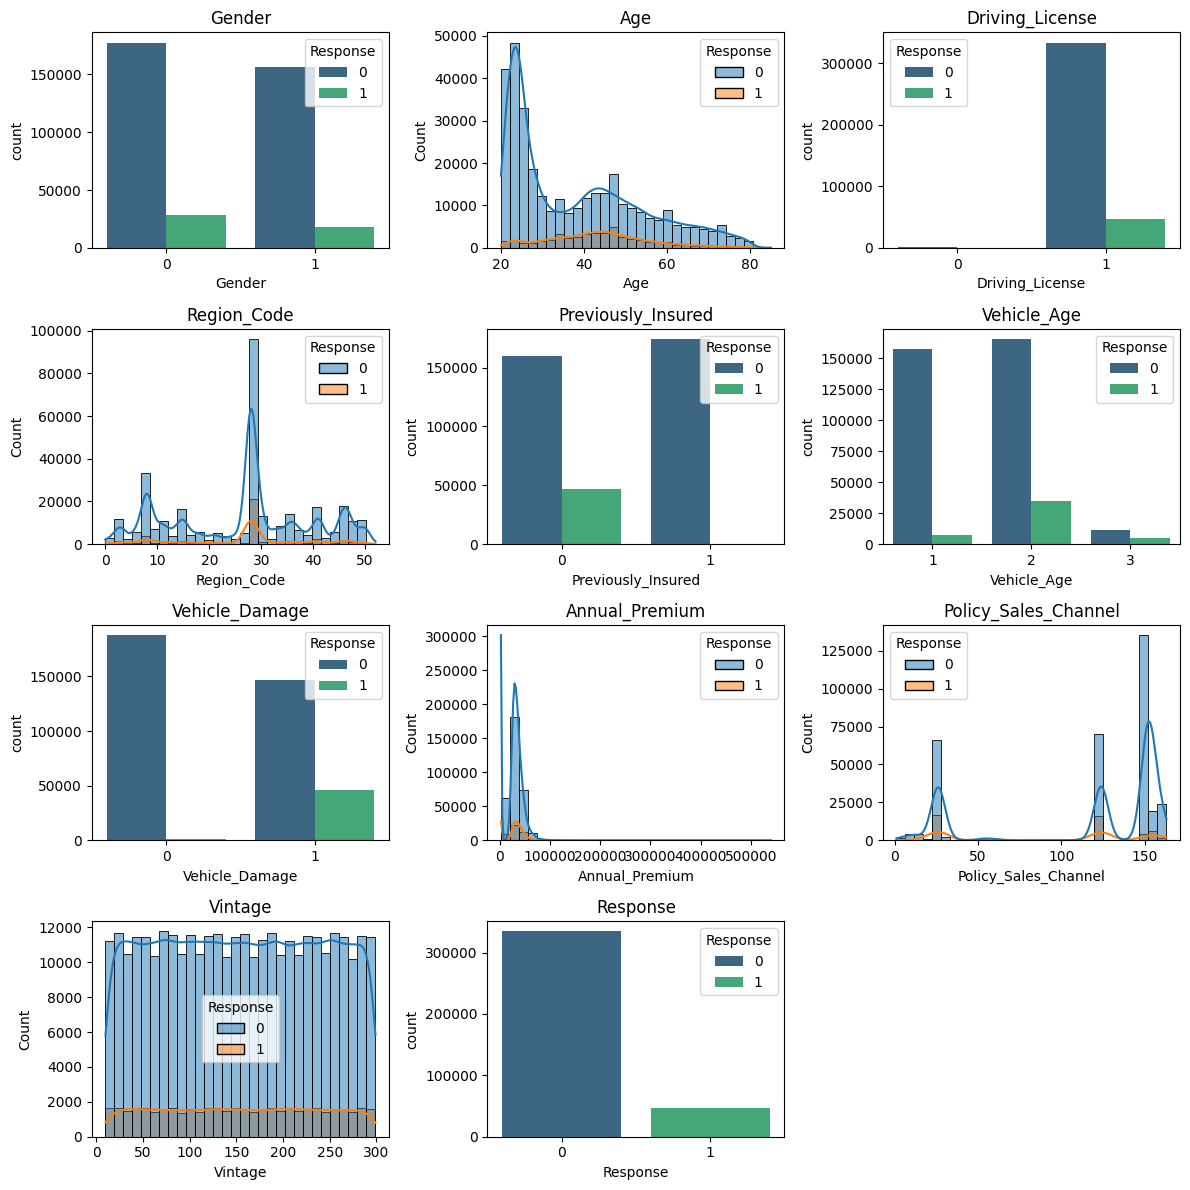

In [ ]:
plot_feature_distribution(df_raw)

Dai plot si evincono alcune cose:<br>
- Dobbiamo ripulire Annual_Premium, andando a fare un pruning<br>
- Vintange è molto uniforme e tutti i sample con valore < 2000 sembrano di essere in favore<br>
- Vehicle_Damage sembra essere un fattore decisionale<br>
- Previously_Insured pure<br>
- Vehicle_Age lascia un po' in dubbio perchè ha entrambi le classi in ogni categoria, quindi introduce un fattore probabilistico<br>
- Gender pure<br>
- Policy_Sales_Channel ha 2 canali di comunicazione più forti rispetto<br>
- Age sembra incorporare una tendenza che potrebbe tornare utile<br>
- Region_Code ha solo 1-2 categorie che potrebbero favorire una risposta positiva, ma potrebbe introdurre un forte bias verso quelle regioni specifiche<br>
- Driving_License mostra chiaramente che chi non ha la patente non è interessato a farsi l'assicurazione sull'auto<br>

Ripuliamo Annual_Premium andando a rimuovere tutte le occorrenze che stanno al di sopra dei 75k (Valore preso ad occhio dai plot di sopra)

In [ ]:
df_raw.drop(df_raw[df_raw["Annual_Premium"] > 75000].index, inplace=True)

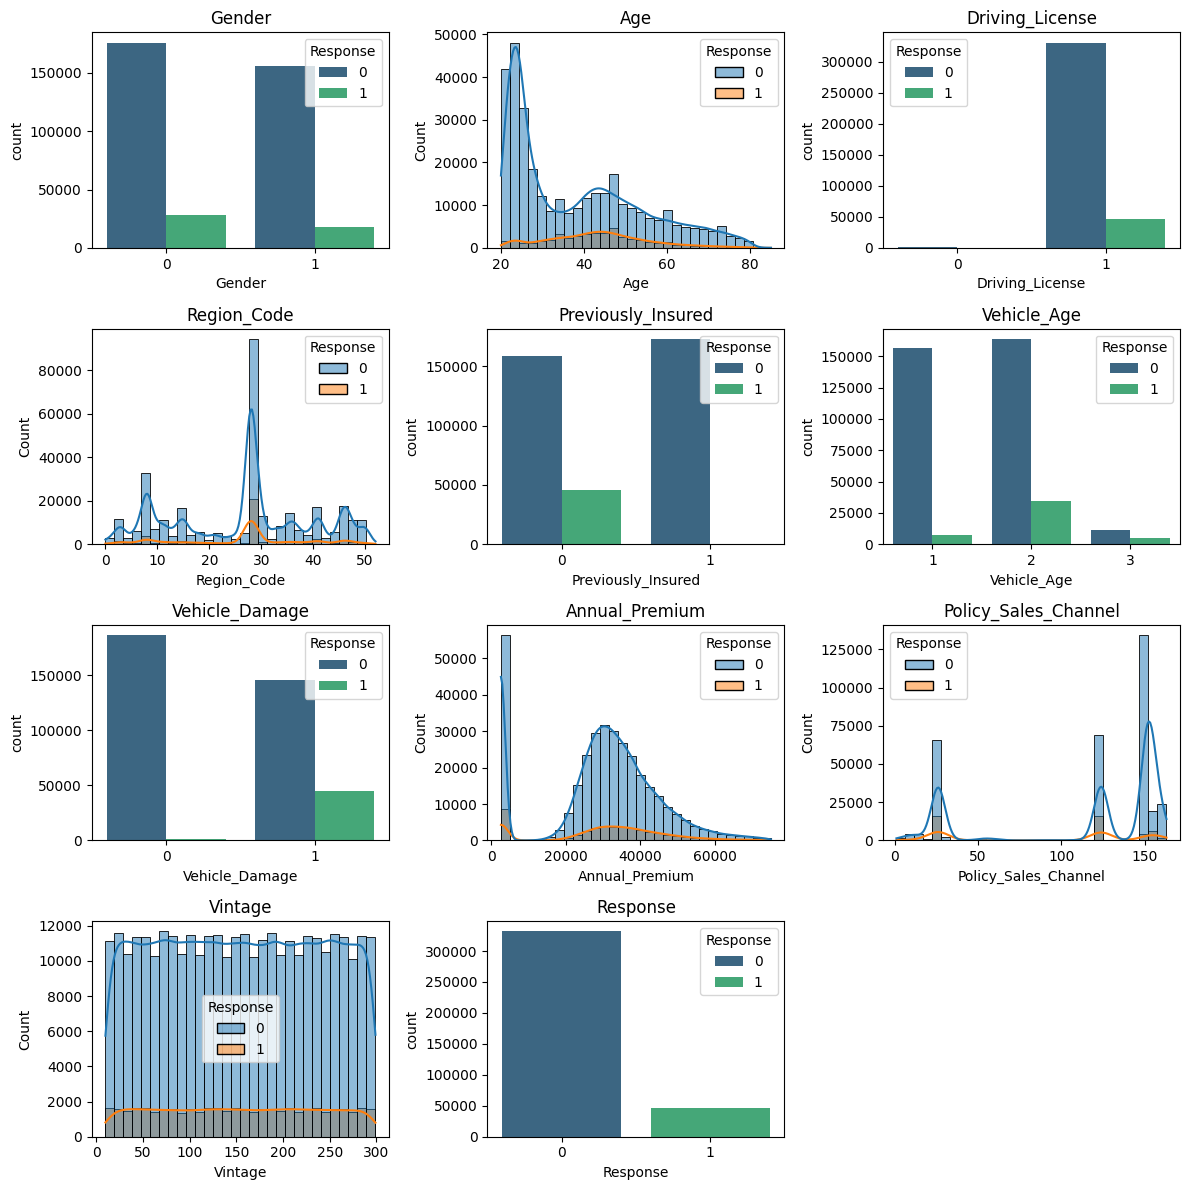

In [ ]:
plot_feature_distribution(df_raw)

Con Annual_Premium ripulito, vediamo che:<br>
- abbiamo rimosso gli outlier (ovviamente questo implica la rimozione di dati che avremmo potuto usare per l'addestramento, ma avrebbero influito sull'efficacia)<br>
- Valori sotto i 5k aumentano la probabilità di una risposta positiva<br>


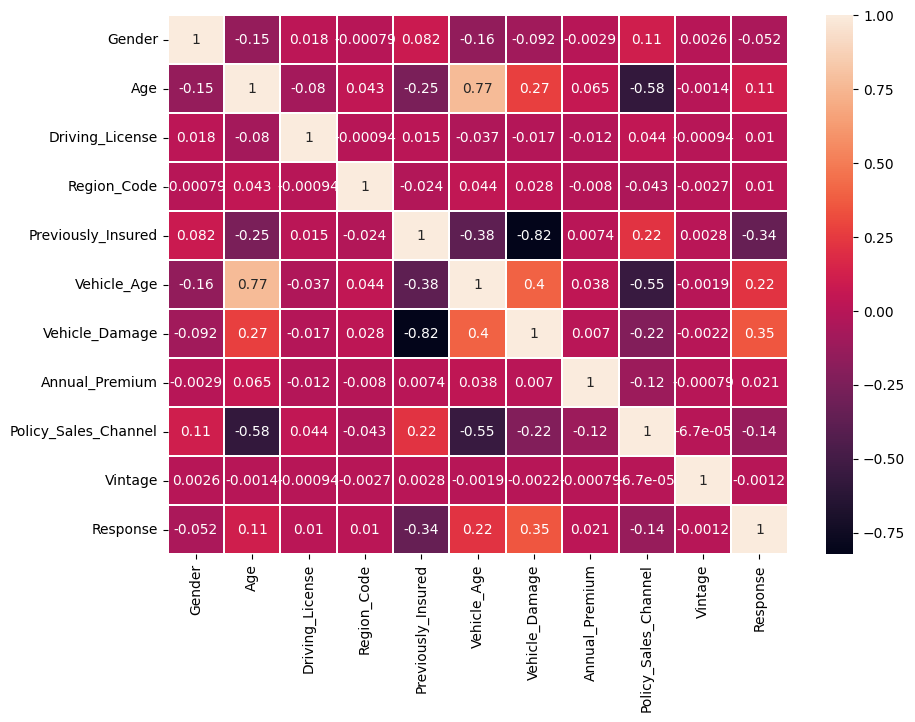

In [ ]:
plot_correlation_matrix(df_raw)

La matrice di correlazione mostra come le varie feature siano correlate con altre feature.<br>
In particolare si vede che:<br>
- Previously_Insured, Vehicle_Age, Vehicle_Damage hanno un impatto più diretto sulla Response<br>
- Policy_Sales_Channel è correlata con Age, quindi il canale di comunicazione dipende dalla target audience, ed influisce lievemente sulla Response<br>
- Age ha un lieve impatto sulla Response dato che sono maggiormente i giovani ad accettare di farsi una polizza assicurativa come visto nei plot precedenti<br>
- Annual_Premium, nonostante il pruning, non sembra avere un impatto notevole sulla Response

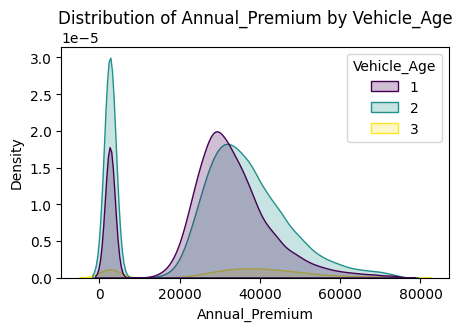

In [ ]:
plot_cross_feature_distribution(df_raw, "Annual_Premium", "Vehicle_Age")

Plottando la distribuzione di Annual_Premium rispetto a Vehicle_Age si vede che i veicoli più nuovi pagano tendenzialmente di più nelle assicurazioni, rispetto a veicoli (3) più vecchi.

Come si vede dai vari grafici, alcune feature sono estremamente correlate tra di loro.

# Preprocessing del dataset
Il preprocessing del dataset consiste semplicemente nel normalizzare le varie feature.<br>
Le feature categoriche furono già codificate dopo il caricamento del dataframe ad inizio notebook.

In [ ]:
def preprocess_data(features, X_train, X_test, y_train, y_test):
    """
    Preprocessa i dati per l'addestramento del modello, normalizzando le feature numeriche.
    """
    X_train = X_train.copy()
    X_test = X_test.copy() if X_test is not None else None

    # Frequency encoding
    if "Policy_Sales_Channel" in features:
        freq_map = X_train["Policy_Sales_Channel"].value_counts(normalize=True)
        X_train.loc[:, "Policy_Sales_Channel"] = X_train["Policy_Sales_Channel"].map(freq_map)
        if X_test is not None:
            X_test.loc[:, "Policy_Sales_Channel"] = X_test["Policy_Sales_Channel"].map(freq_map).fillna(freq_map.min())

    # Scaling
    std_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler()

    std_cols = ["Annual_Premium", "Vintage"]
    minmax_cols = ["Age", "Policy_Sales_Channel", "Region_Code", "Vehicle_Age"]

    # Just for dynamic filtering of features to scale
    minmax_cols = [col for col in minmax_cols if col in features]
    std_cols = [col for col in std_cols if col in features]

    # Scale and assign using DataFrame to prevent SettingWithCopyWarning
    if len(std_cols) > 0:
        X_train[std_cols] = pd.DataFrame(std_scaler.fit_transform(X_train[std_cols]), columns=std_cols, index=X_train.index)
        if X_test is not None:
            X_test[std_cols] = pd.DataFrame(std_scaler.transform(X_test[std_cols]), columns=std_cols, index=X_test.index)

    if len(minmax_cols) > 0:
        X_train[minmax_cols] = pd.DataFrame(minmax_scaler.fit_transform(X_train[minmax_cols]), columns=minmax_cols, index=X_train.index)
        if X_test is not None:
            X_test[minmax_cols] = pd.DataFrame(minmax_scaler.transform(X_test[minmax_cols]), columns=minmax_cols, index=X_test.index)

    return X_train, X_test, y_train, y_test

In [ ]:
def eval_model(model, X, y, plot_metrics=True, plot_matrix=True, plot_pr_curve=False):
    """
    Valuta il modello e plotta le metriche di valutazione.
    Ritorna le predizioni del modello e le probabilità di predizione.
    """
    y_pred = model.predict(X)
    y_pred_probs = model.predict_proba(X)

    if plot_metrics:
        print(classification_report(y, y_pred))

    if plot_matrix:
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    if plot_pr_curve:
        precision, recall, thresholds = precision_recall_curve(y, y_pred_probs[:, 1])
        avg_prec = average_precision_score(y, y_pred_probs[:, 1])

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, marker='.', label=f'PR Curve (AP = {avg_prec:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid()
        plt.show()

    return y_pred, y_pred_probs

# Modello di base
Addestramento con dati grezzi senza preprocessing (scaling).<br>
Usato come modello di riferimento.

              precision    recall  f1-score   support

           0       1.00      0.52      0.69    265380
           1       0.22      1.00      0.37     36876

    accuracy                           0.58    302256
   macro avg       0.61      0.76      0.53    302256
weighted avg       0.90      0.58      0.65    302256



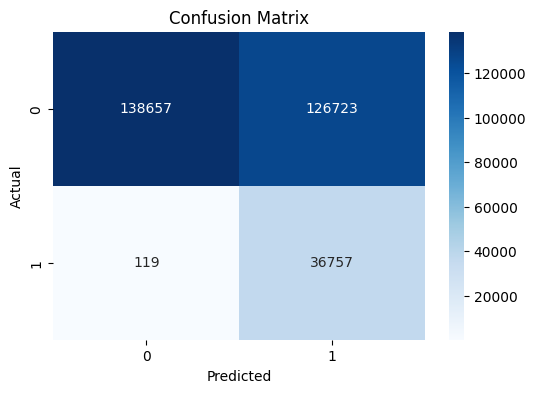

              precision    recall  f1-score   support

           0       1.00      0.52      0.68     66225
           1       0.23      1.00      0.37      9339

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.58      0.65     75564



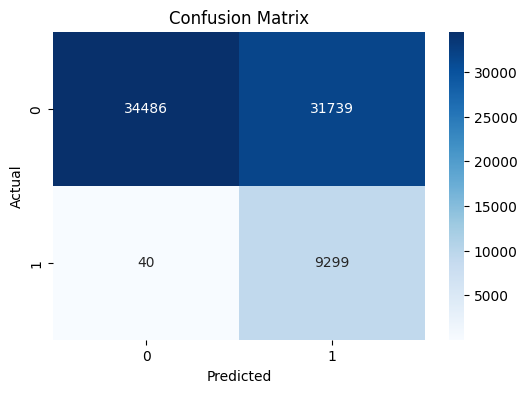

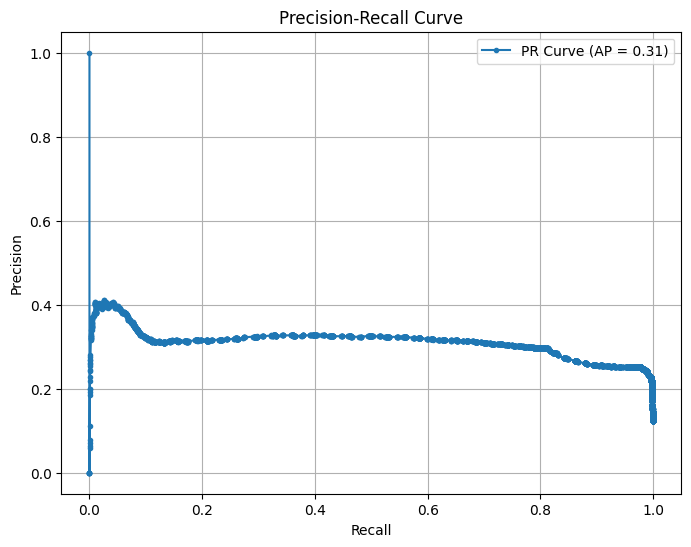

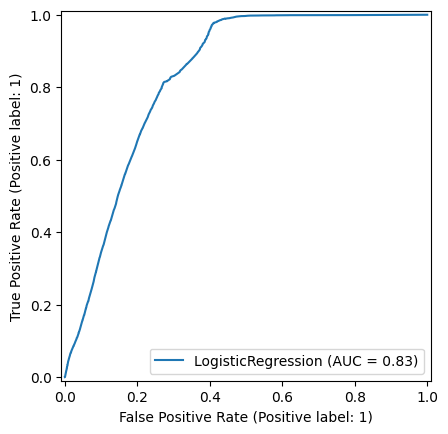

In [ ]:
#selected_features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Gender", "Age", "Policy_Sales_Channel", "Annual_Premium"]
selected_features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Age", "Policy_Sales_Channel"]
#selected_features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Age", "Annual_Premium", "Vintage"]
#selected_features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Age", "Annual_Premium", "Region_Code", "Policy_Sales_Channel"]
#selected_features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Age", "Region_Code"]

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_raw[selected_features].drop("Response", axis=1), df_raw["Response"], test_size=0.2, random_state=RNG_SEED)

lr_base = LogisticRegression(class_weight={0: 0.5, 1: 27}, max_iter=100000, random_state=RNG_SEED)
lr_base.fit(X_train_base, y_train_base)
eval_model(lr_base, X_train_base, y_train_base)
eval_model(lr_base, X_test_base, y_test_base, plot_pr_curve=True)
RocCurveDisplay.from_estimator(lr_base, X_test_base, y_test_base)

L'unica combinazione di feature che dia una AUC buona (AUC = 0.83) è:<br>
* Previously_Insured
* Vehicle_Damage
* Vehicle_Age
* Age
* Annual_Premium
* (e/o Vintage)
<br><br>

Dato l'obiettivo di individuare quante più opportunità di vendita possibili, siamo principalmente interessati a raggiungere un Recall di 1.0.<br>

Il recall indica il grado di confidenza del nostro modello di classificare una determinata classe, qui la classe 1.<br><br>
Questo implica il dover scendere a compromessi:<br>
1. Aumentando il recall, aumentano i falsi positivi, ma scendono i falsi negativi
2. Si bilancia con il recall della classe opposta -> Non possiamo raggiungere Recall = 1 in entrambe le classi contemporaneamente
<br>

Dato che il nostro dataset è estremamente sbilanciato, per raggiungere questo risultato abbiamo dovuto aumentare i coefficienti che il modello usa internamente per penalizzare le classificazioni errate rispetto ad una classe specifica.<br><br>

In sostanza questo modello di base, così, non sarebbe affidabile in un caso reale di business. I pesi assegnati sono troppo sbilanciati, favorendo (molto) di più una classe rispetto all'altra.<br>
Vediamo se con qualche tecnica di preprocessing dei dati si riesce ad estrarre qualche metrica migliore.

# Modello di previsione 1
Addestramento con dati preprocessati e undersampling della classe maggiore usando tutte le feature e regolarizzazione L1.

In [ ]:
df = df_raw.copy()

# Feature selection
df = df[selected_features]

# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(df.drop("Response", axis=1), df["Response"], test_size=0.2, random_state=RNG_SEED)

# Undersampling
under_sampler = RandomUnderSampler(sampling_strategy="majority", random_state=RNG_SEED)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
print(Counter(y_train))

X_train, X_test, y_train, y_test = preprocess_data(selected_features, X_train, X_test, y_train, y_test)

Counter({0: 36876, 1: 36876})


              precision    recall  f1-score   support

           0       0.99      0.52      0.68     36876
           1       0.68      1.00      0.81     36876

    accuracy                           0.76     73752
   macro avg       0.83      0.76      0.74     73752
weighted avg       0.83      0.76      0.74     73752



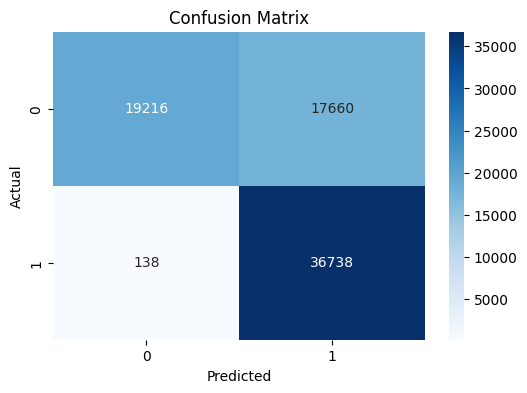

              precision    recall  f1-score   support

           0       1.00      0.52      0.69     66225
           1       0.23      1.00      0.37      9339

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.58      0.65     75564



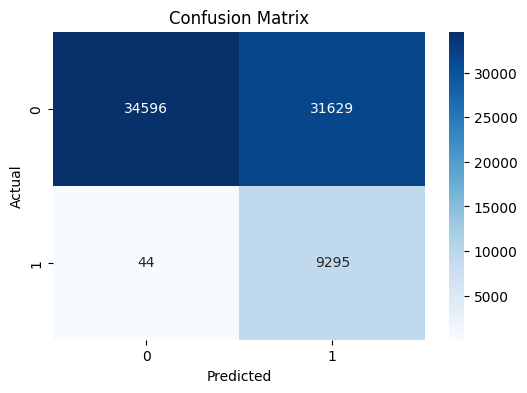

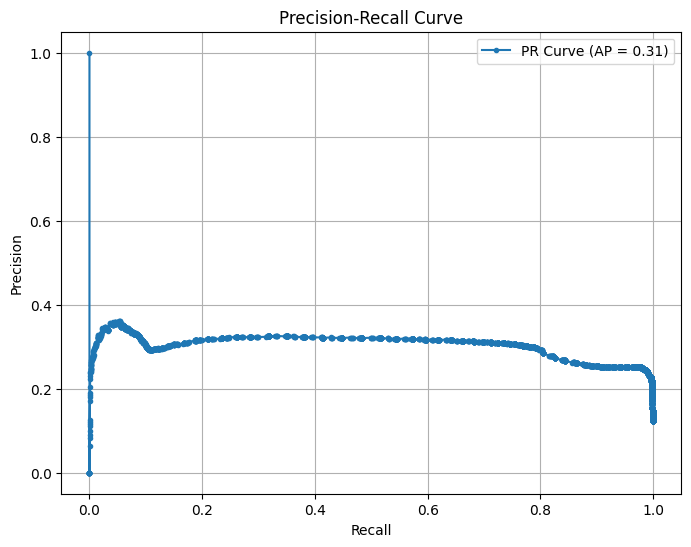

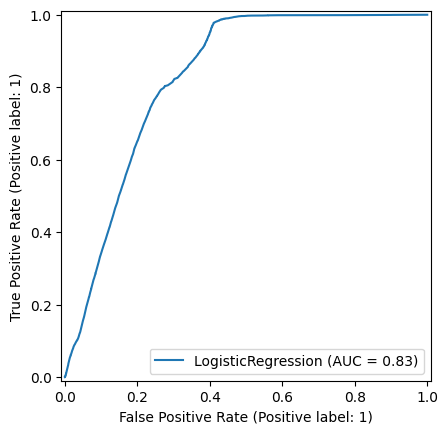

In [ ]:
lr1 = LogisticRegression(class_weight={0: 1.0, 1: 6.0}, penalty="l1", solver="saga", max_iter=10000, random_state=RNG_SEED)
lr1.fit(X_train, y_train)
eval_model(lr1, X_train, y_train)
eval_model(lr1, X_test, y_test, plot_pr_curve=True)
RocCurveDisplay.from_estimator(lr1, X_test, y_test)

Il preprocessing con l'undersampling del dataset ha portato a qualche miglioramento del modello.<br>
<br>
Sul training set, la precision è passata da 0.21 a 0.68 e f1-score da 0.35 a 0.81.<br>
Sul validation set, però, è migliorato solo di 2 punti (precision: 0.21 -> 0.23 e f1-score: 0.35 -> 0.37).<br>
<br>
La AUC, invece, è rimasta invariata. <br>
Infine, i pesi associati alle classi sono molto più bassi rispetto al modello di base, implicando quindi che i dati sono molto più bilanciati rispetto a prima.

# Modello di previsione 2
Estensione del modello 1, ma con l'aggiunta della KFold cross validation.<br>
<br>
Con la KFold cross-validation effettuiamo uno split dei dati in 5 segmenti, applichiamo l'undersampling solo sul train-set, ed infine verrà addestrata la LogisticRegression per ogni segmento, calcolando le varie metriche per valutarne l'efficacia.

In [ ]:
def select_features(df, features):
    """
    Seleziona le feature da utilizzare per il modello 2.
    Ritorna il dataset preprocessato e le target.

    features: lista di stringhe con i nomi delle feature da utilizzare
    """
    data = df[features].copy()
    X = data.drop("Response", axis=1)
    y = data["Response"]

    return X, y

In [ ]:
def logistic_cross_validation(X, y, weights, plot_metrics_=True, plot_matrix_=True, plot_pr_curve_=True, penalty_="l1", solver_="saga", c_=1.0, undersample_strategy=None, oversample_strategy=None):
    """
    Effettua la cross-validation con KFold per il modello di regressione logistica.
    Ritorna una lista di tuple (y_test, y_pred, y_pred_probs) per ogni segmento.

    weights: dizionario con i pesi delle classi
    plot_metrics_: se True, plotta le metriche di valutazione
    plot_matrix_: se True, plotta la matrice di confusione
    plot_pr_curve_: se True, plotta la curva PR
    penalty_: tipo di regolarizzazione da utilizzare
    solver_: algoritmo di ottimizzazione da utilizzare
    c_: parametro di regolarizzazione
    """
    kfold = KFold(n_splits=5, shuffle=True, random_state=RNG_SEED)

    scores = {
        "accuracy": [],
        "recall": [],
        "precision": [],
        "f1": []
    }

    y_predicted_probabilities = []

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, X_test, y_train, y_test = preprocess_data(X.columns, X_train, X_test, y_train, y_test)

        if undersample_strategy is not None:
            under_sampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=RNG_SEED)
            X_train, y_train = under_sampler.fit_resample(X_train, y_train)
            #print("Undersample: ", Counter(y_train))
            # Il test set lo lasciamo con la distribuzione reale

        if oversample_strategy is not None:
            over_sampler = SMOTE(sampling_strategy=oversample_strategy, random_state=RNG_SEED)
            X_train, y_train = over_sampler.fit_resample(X_train, y_train)
            #print("Oversample: ", Counter(y_train))
            # Il test set lo lasciamo con la distribuzione reale

        lr = LogisticRegression(class_weight=weights, penalty=penalty_, solver=solver_, max_iter=10000, C=c_, random_state=RNG_SEED)
        lr.fit(X_train, y_train)
        print("Train:")
        eval_model(lr, X_train, y_train, plot_metrics=plot_metrics_, plot_matrix=False)
        print("Test:")
        y_pred, y_pred_probs = eval_model(lr, X_test, y_test, plot_metrics=plot_metrics_, plot_matrix=plot_matrix_, plot_pr_curve=plot_pr_curve_)
        print("-------------------------------")

        y_predicted_probabilities.append((y_test, y_pred, y_pred_probs))

        scores["accuracy"].append(accuracy_score(y_test, y_pred))
        scores["recall"].append(recall_score(y_test, y_pred))
        scores["precision"].append(precision_score(y_test, y_pred))
        scores["f1"].append(f1_score(y_test, y_pred))

    print("Accuracy:", np.mean(scores["accuracy"]))
    print("Recall:", np.mean(scores["recall"]))
    print("Precision:", np.mean(scores["precision"]))
    print("F1-Score:", np.mean(scores["f1"]))

    return y_predicted_probabilities

In [ ]:
def plot_prob_dist(y_pred_probs, threshold):
    """
    Plotta la distribuzione delle probabilità di predizione per una classe specifica.

    y_pred_probs: array di probabilità di predizione
    threshold: soglia di classificazione
    """
    plt.figure(figsize=(4, 3))
    sns.histplot(y_pred_probs[y_test == 1], bins=30, color='blue', label="Positive Class (1)", alpha=0.6)
    sns.histplot(y_pred_probs[y_test == 0], bins=30, color='red', label="Negative Class (0)", alpha=0.6)
    plt.axvline(threshold, color='black', linestyle='dashed', label=f"Decision Threshold ({threshold:.2f})")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.legend()
    plt.title("Distribution of Predicted Probabilities")
    plt.show()

def plot_label_probs(y_test, y_pred_probs, threshold):
    """
    Plotta la distribuzione delle probabilità di predizione rispetto alle target.

    y_test: array di target
    y_pred_probs: array di probabilità di predizione
    threshold: soglia di classificazione
    """
    plt.figure(figsize=(4, 3))
    sns.stripplot(x=y_test, y=y_pred_probs, jitter=True, alpha=0.5)
    plt.axhline(threshold, color='black', linestyle='dashed', label=f"Decision Threshold ({threshold:.2f})")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Probability")
    plt.title("Predicted Probabilities vs. True Labels")
    plt.legend()
    plt.show()

def plot_model_preds(y, y_pred_probs, threshold=0.5, plot_metrics=True, plot_matrix=True, plot_pr_curve=False):
    """
    Plotta i risultati del modello di classificazione utilizzando le probabilità di predizione.

    y: array di target
    y_pred_probs: array di probabilità di predizione
    threshold: soglia di classificazione
    plot_metrics: se True, plotta le metriche di valutazione
    plot_matrix: se True, plotta la matrice di confusione
    plot_pr_curve: se True, plotta la curva PR
    """
    y = np.array(y) if isinstance(y, pd.Series) else y

    if y_pred_probs.ndim == 2 and y_pred_probs.shape[1] == 2:
        pos_probs = y_pred_probs[:, 1]
    else:
        pos_probs = y_pred_probs

    y_pred = (pos_probs >= threshold).astype(int)

    # Print classification report
    if plot_metrics:
        print(classification_report(y, y_pred))

    # Plot confusion matrix
    if plot_matrix:
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    # Plot Precision-Recall Curve
    if plot_pr_curve:
        precision, recall, _ = precision_recall_curve(y, pos_probs)
        avg_prec = average_precision_score(y, pos_probs)

        plt.figure(figsize=(4, 3))
        plt.plot(recall, precision, marker='.', label=f'PR Curve (AP = {avg_prec:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid()
        plt.show()

Train:
              precision    recall  f1-score   support

           0       0.99      0.52      0.69     36876
           1       0.68      1.00      0.81     36876

    accuracy                           0.76     73752
   macro avg       0.83      0.76      0.75     73752
weighted avg       0.83      0.76      0.75     73752

Test:
              precision    recall  f1-score   support

           0       1.00      0.52      0.69     66225
           1       0.23      1.00      0.37      9339

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.58      0.65     75564



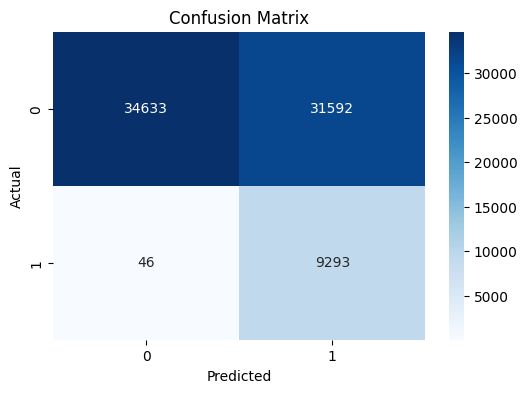

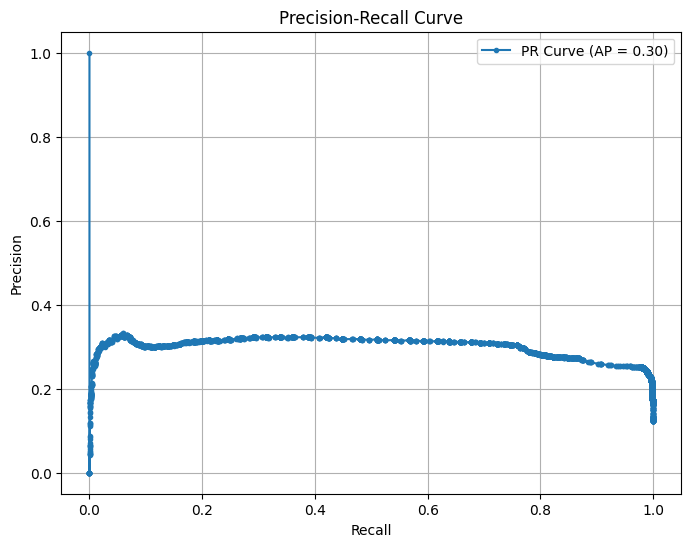

-------------------------------
Train:
              precision    recall  f1-score   support

           0       0.99      0.52      0.68     36986
           1       0.68      1.00      0.80     36986

    accuracy                           0.76     73972
   macro avg       0.83      0.76      0.74     73972
weighted avg       0.83      0.76      0.74     73972

Test:
              precision    recall  f1-score   support

           0       1.00      0.52      0.69     66335
           1       0.23      1.00      0.37      9229

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.58      0.65     75564



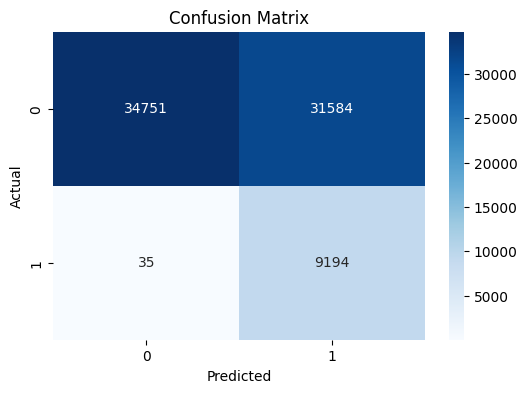

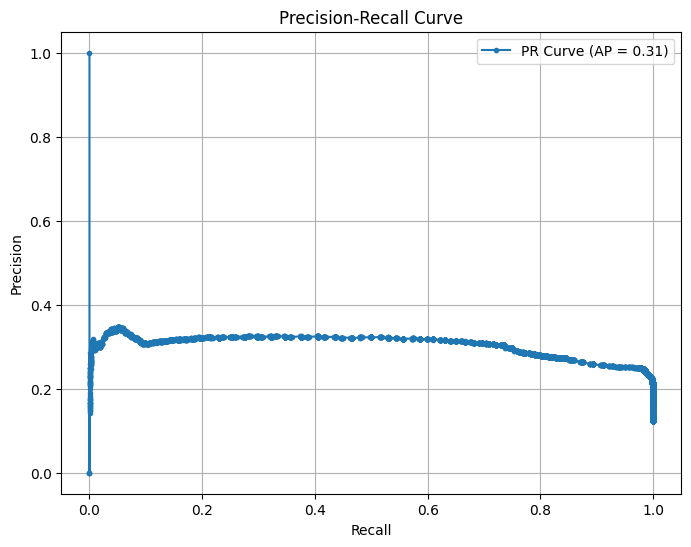

-------------------------------
Train:
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     37089
           1       0.68      1.00      0.81     37089

    accuracy                           0.76     74178
   macro avg       0.84      0.76      0.75     74178
weighted avg       0.84      0.76      0.75     74178

Test:
              precision    recall  f1-score   support

           0       1.00      0.52      0.69     66438
           1       0.22      1.00      0.36      9126

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.91      0.58      0.65     75564



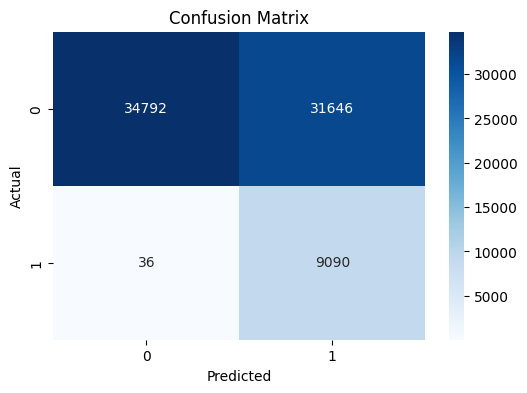

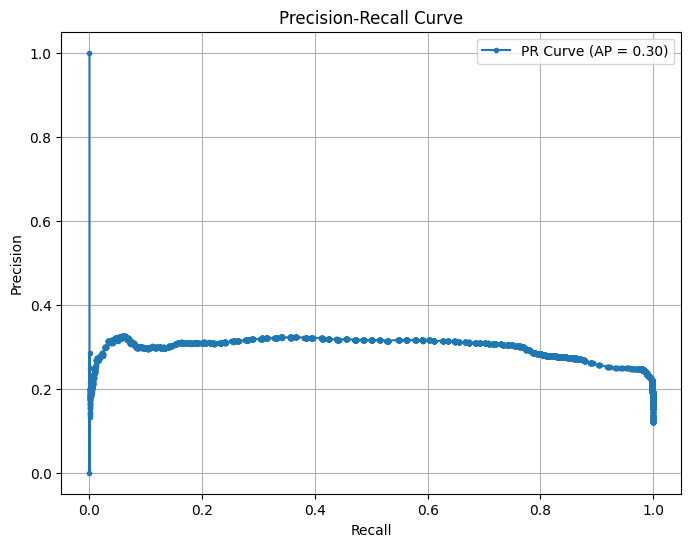

-------------------------------
Train:
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     36962
           1       0.68      1.00      0.81     36962

    accuracy                           0.76     73924
   macro avg       0.83      0.76      0.75     73924
weighted avg       0.83      0.76      0.75     73924

Test:
              precision    recall  f1-score   support

           0       1.00      0.53      0.69     66311
           1       0.23      1.00      0.37      9253

    accuracy                           0.59     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.59      0.65     75564



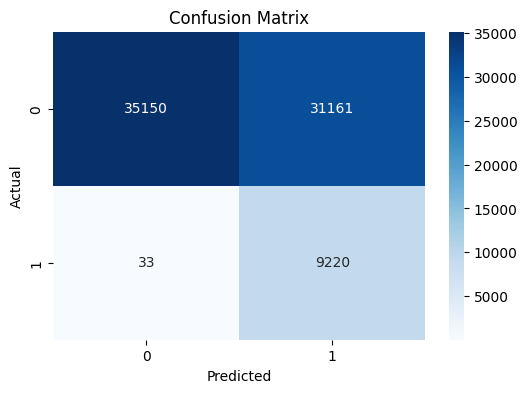

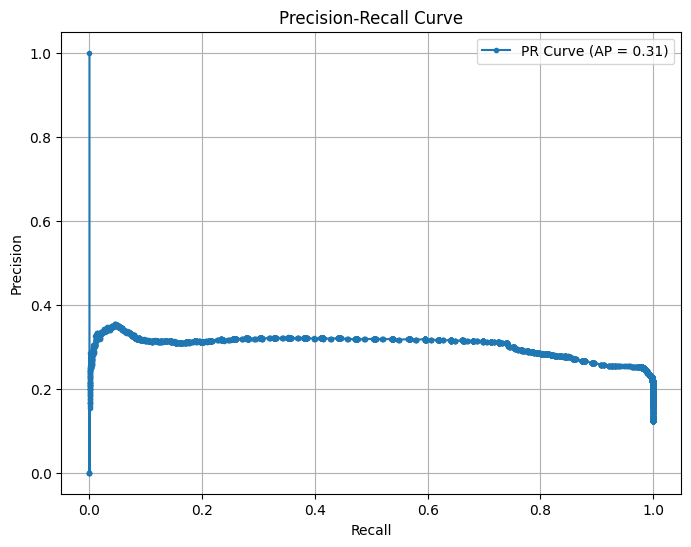

-------------------------------
Train:
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     36947
           1       0.68      1.00      0.81     36947

    accuracy                           0.76     73894
   macro avg       0.83      0.76      0.75     73894
weighted avg       0.83      0.76      0.75     73894

Test:
              precision    recall  f1-score   support

           0       1.00      0.52      0.69     66296
           1       0.23      1.00      0.37      9268

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.58      0.65     75564



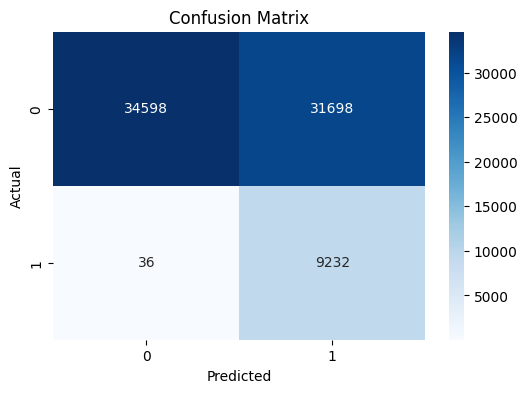

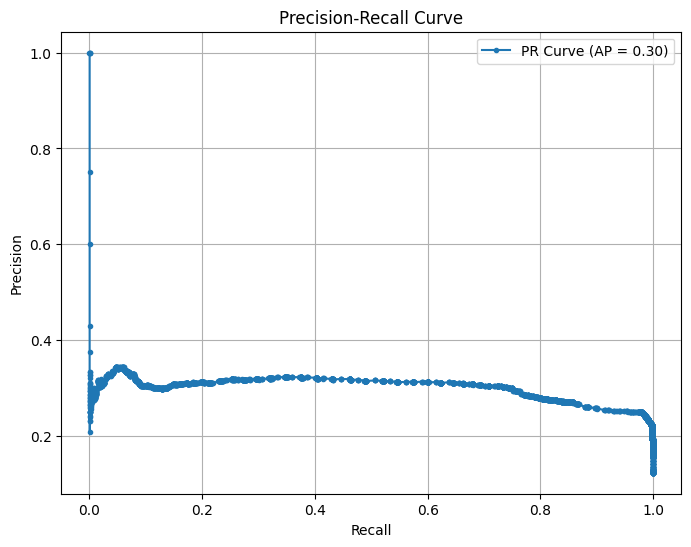

-------------------------------
Accuracy: 0.582163464083426
Recall: 0.9959773016603635
Precision: 0.22595719257398955
F1-Score: 0.3683439796188726


In [ ]:
X, y = select_features(df_raw, selected_features)
_ = logistic_cross_validation(X, y, weights={0: 1, 1: 6}, undersample_strategy="majority")

Con questo approcio abbiamo metriche un pò diverse:<br>
1. Accuracy invariata (anche se è un parametro di poca importanza per dataset sbilanciati)
2. Recall ~1, sempre con class weights uguali al modello precedente
3. Precision ~0.225 sul validation set (sul training set è sui ~0.67)
4. F1-Score invariata
<br>
<br>
Il modello potrebbe essere già utilizzabile così ma bisogna tenere conto del fatto che non fu addestrato sull'intero dataset (abbiamo fatto l'undersampling della classe maggiore!)<br>
<br>
Proviamo con qualche combinazione aggiuntiva di Oversampling.

# Modello di previsione 3
Estensione del modello 2 ma con l'aggiunta di SMOTE (Oversampling con generazione sintentica della classe in minoranza).

In [ ]:
#features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Policy_Sales_Channel"]
features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Annual_Premium"]
#features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Annual_Premium", "Age"]
#features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Annual_Premium", "Policy_Sales_Channel"]
X, y = select_features(df_raw, features)

Train:
              precision    recall  f1-score   support

           0       0.99      0.52      0.68     49168
           1       0.68      1.00      0.81     49168

    accuracy                           0.76     98336
   macro avg       0.84      0.76      0.75     98336
weighted avg       0.84      0.76      0.75     98336

Test:
              precision    recall  f1-score   support

           0       1.00      0.52      0.68     66225
           1       0.23      1.00      0.37      9339

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.58      0.65     75564



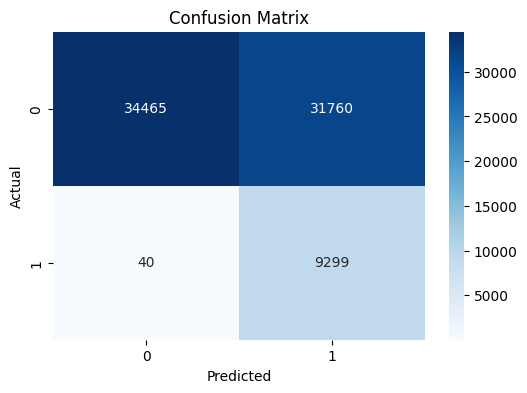

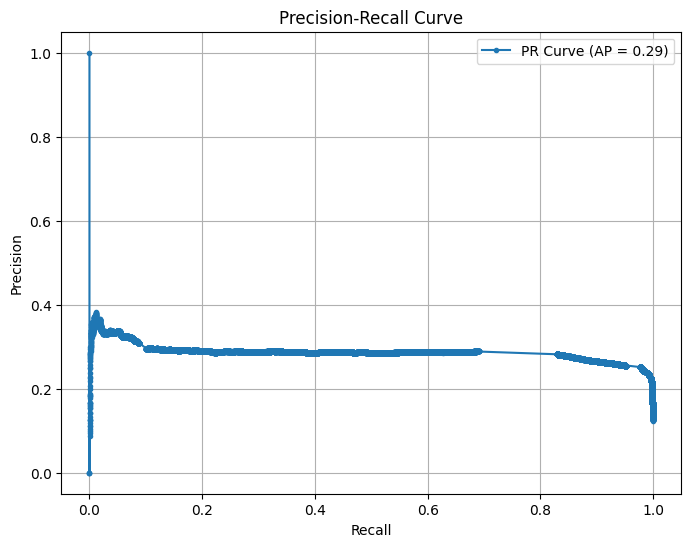

-------------------------------
Train:
              precision    recall  f1-score   support

           0       0.99      0.52      0.68     49314
           1       0.67      1.00      0.80     49314

    accuracy                           0.76     98628
   macro avg       0.83      0.76      0.74     98628
weighted avg       0.83      0.76      0.74     98628

Test:
              precision    recall  f1-score   support

           0       1.00      0.52      0.69     66335
           1       0.23      1.00      0.37      9229

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.58      0.65     75564



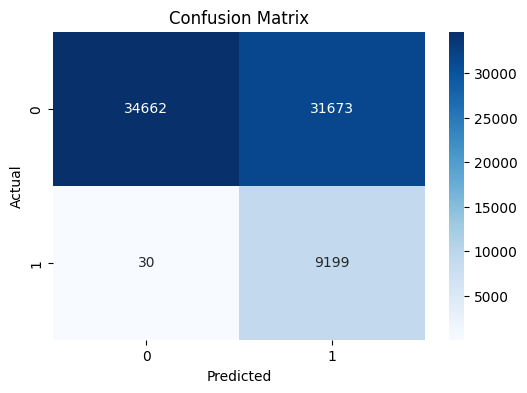

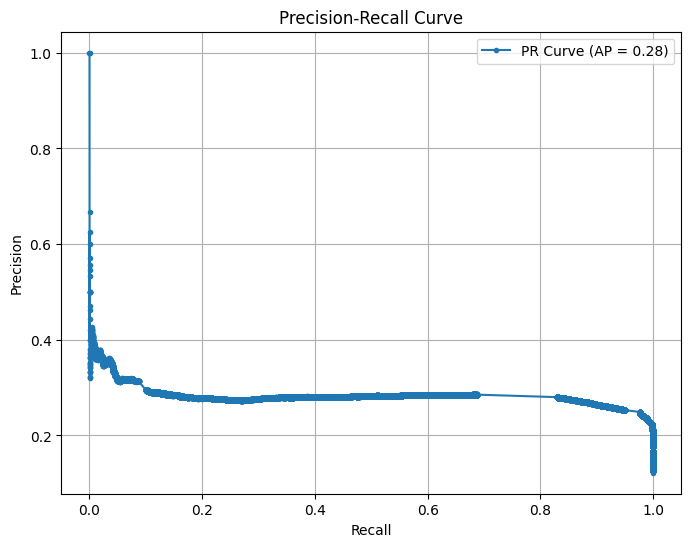

-------------------------------
Train:
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     49452
           1       0.68      1.00      0.81     49452

    accuracy                           0.76     98904
   macro avg       0.84      0.76      0.75     98904
weighted avg       0.84      0.76      0.75     98904

Test:
              precision    recall  f1-score   support

           0       1.00      0.52      0.69     66438
           1       0.22      1.00      0.36      9126

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.52     75564
weighted avg       0.91      0.58      0.65     75564



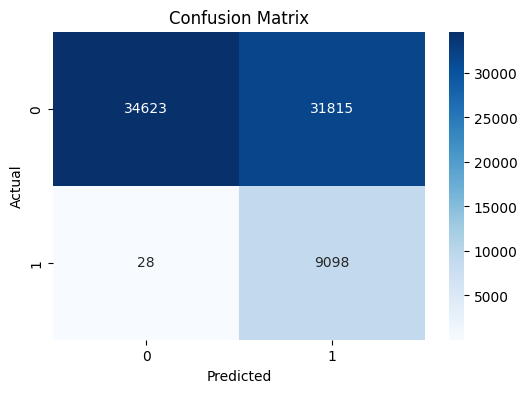

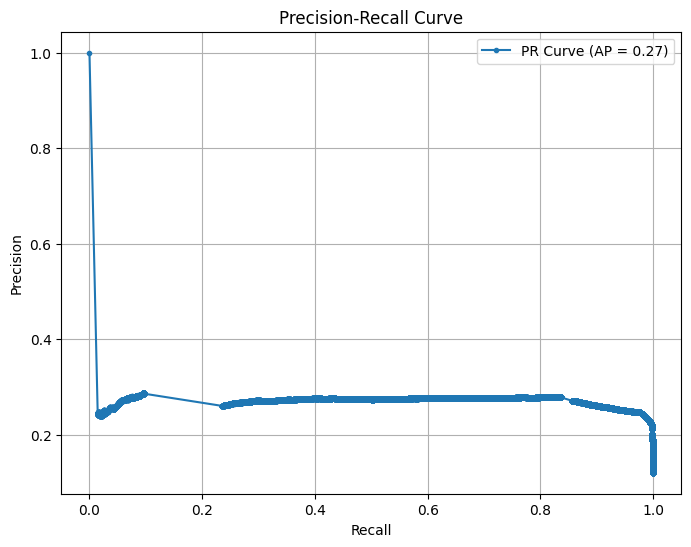

-------------------------------
Train:
              precision    recall  f1-score   support

           0       0.99      0.52      0.69     49282
           1       0.68      1.00      0.81     49282

    accuracy                           0.76     98564
   macro avg       0.83      0.76      0.75     98564
weighted avg       0.83      0.76      0.75     98564

Test:
              precision    recall  f1-score   support

           0       1.00      0.53      0.69     66311
           1       0.23      1.00      0.37      9253

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.58      0.65     75564



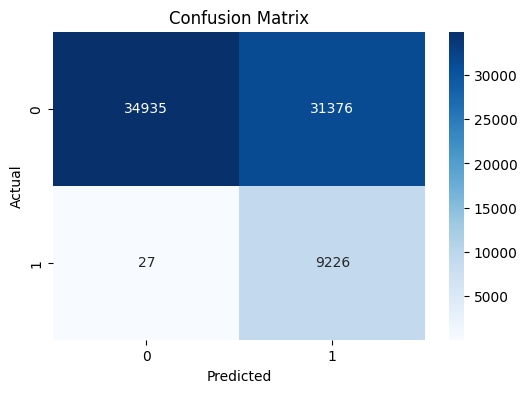

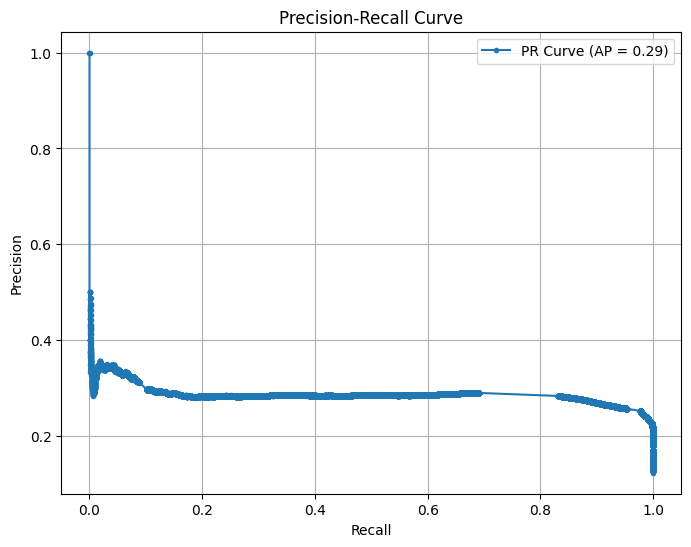

-------------------------------
Train:
              precision    recall  f1-score   support

           0       0.99      0.52      0.68     49262
           1       0.68      1.00      0.81     49262

    accuracy                           0.76     98524
   macro avg       0.83      0.76      0.74     98524
weighted avg       0.83      0.76      0.74     98524

Test:
              precision    recall  f1-score   support

           0       1.00      0.52      0.68     66296
           1       0.22      1.00      0.37      9268

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.52     75564
weighted avg       0.90      0.58      0.64     75564



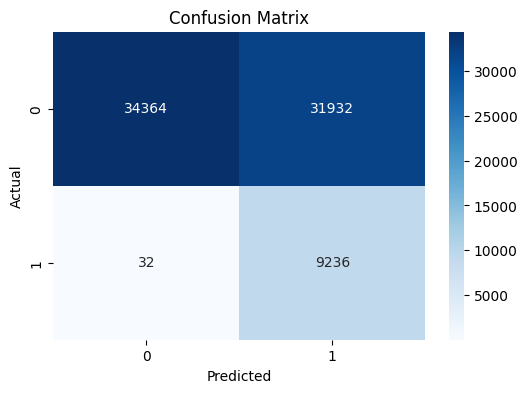

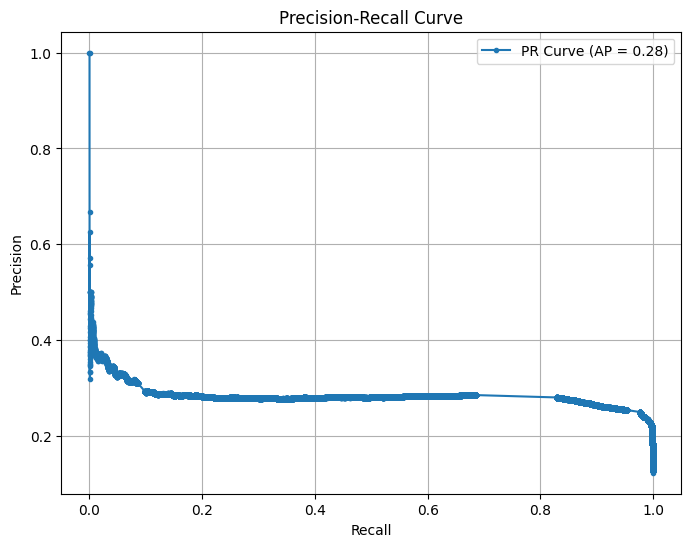

-------------------------------
Accuracy: 0.5799243025779472
Recall: 0.9966054786127106
Precision: 0.22510019538888684
F1-Score: 0.36724736474657815


In [ ]:
y_predicted_probs_3 = logistic_cross_validation(X, y, weights={0: 1, 1: 6}, undersample_strategy=0.75, oversample_strategy=1.0)

```
# Metriche Modello 2
Accuracy: 0.582163464083426
Recall: 0.9959773016603635
Precision: 0.22595719257398955
F1-Score: 0.3683439796188726
```

Provando diverse configurazioni di feature e over/undersampling, le metriche rimangono stabili e non variano molto da quelle del modello 2.<br>
<br>
Pertanto, l'oversampling/SMOTE non sembra apportare alcun beneficio in questo caso.


# Modello di previsione 3.1
Modifica del decision boundary threshold per valutarne l'impatto sulla classificazione.

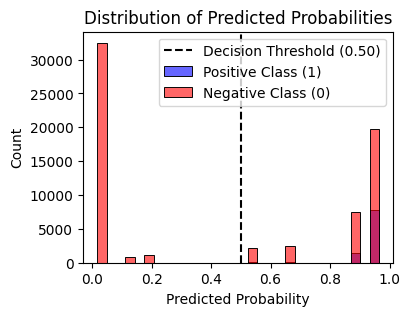

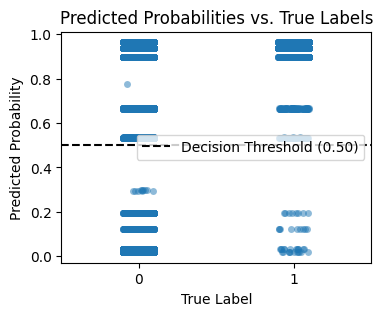

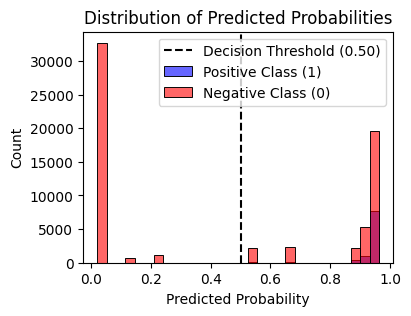

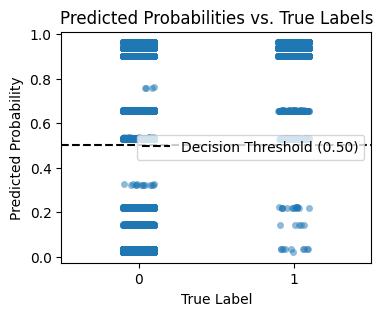

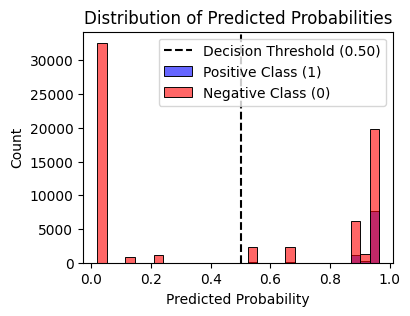

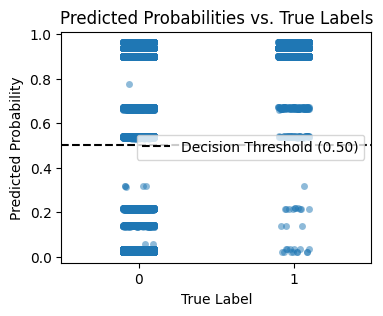

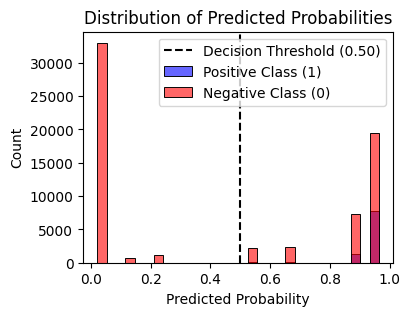

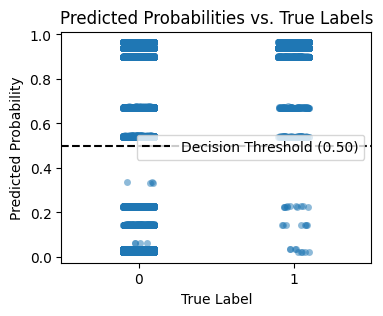

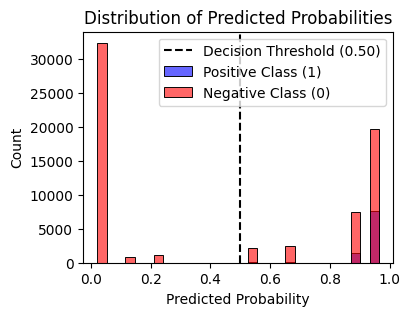

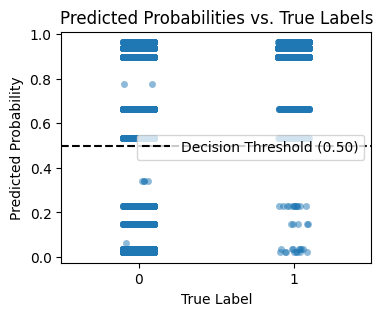

In [ ]:
decision_threshold = 0.5

for y_test, y_pred, y_pred_probs in y_predicted_probs_3:
    plot_prob_dist(y_pred_probs[:, 1], decision_threshold)
    plot_label_probs(y_test, y_pred_probs[:, 1], decision_threshold)
    # break

Plottiamo le classificazioni fatte nel modello 3 con diversi threshold:

In [ ]:
def print_pred_metrics_with_threshold(y_predicted_probs, decision_threshold):
    scores = {
        "accuracy": [],
        "recall": [],
        "precision": [],
        "f1": []
    }

    for y_test, _, y_pred_probs in y_predicted_probs:
        #plot_model_preds(y_test, y_pred_probs, decision_threshold, plot_metrics=False, plot_matrix=False, plot_pr_curve=False)
        #plot_prob_dist(y_pred_probs[:, 1], decision_threshold)
        #plot_label_probs(y_test, y_pred_probs[:, 1], decision_threshold)

        pred_probs = y_pred_probs[:, 1]
        y_pred = (pred_probs >= decision_threshold).astype(int)

        scores["accuracy"].append(accuracy_score(y_test, y_pred))
        scores["recall"].append(recall_score(y_test, y_pred))
        scores["precision"].append(precision_score(y_test, y_pred))
        scores["f1"].append(f1_score(y_test, y_pred))

    print(f"Threshold: {decision_threshold:.2f}")
    print("Accuracy:", np.mean(scores["accuracy"]))
    print("Recall:", np.mean(scores["recall"]))
    print("Precision:", np.mean(scores["precision"]))
    print("F1-Score:", np.mean(scores["f1"]))
    print("--------------------------------")

def print_pred_metrics(y_predicted_probs):
    for step in range(1, 10):
        decision_threshold = step / 10.0
        print_pred_metrics_with_threshold(y_predicted_probs, decision_threshold)

In [ ]:
print_pred_metrics(y_predicted_probs_3)

Threshold: 0.10
Accuracy: 0.5543353978084803
Recall: 0.9984656920806803
Precision: 0.21517372167612545
F1-Score: 0.3540449923857462
--------------------------------
Threshold: 0.20
Accuracy: 0.5677544862633
Recall: 0.9976683266603729
Precision: 0.22031433071554823
F1-Score: 0.36091124427179777
--------------------------------
Threshold: 0.30
Accuracy: 0.5798554867397173
Recall: 0.9966273940192412
Precision: 0.22507431227041677
F1-Score: 0.36721437371304305
--------------------------------
Threshold: 0.40
Accuracy: 0.5799243025779472
Recall: 0.9966054786127106
Precision: 0.22510019538888684
F1-Score: 0.36724736474657815
--------------------------------
Threshold: 0.50
Accuracy: 0.5799243025779472
Recall: 0.9966054786127106
Precision: 0.22510019538888684
F1-Score: 0.36724736474657815
--------------------------------
Threshold: 0.60
Accuracy: 0.6078767667143085
Recall: 0.9889634558163763
Precision: 0.2363915391600183
F1-Score: 0.3815721348551627
--------------------------------
Threshold:

Il threshold di default, 0.5 può restare invariato in questo caso. Avremmo una minima variazione portandolo al di sotto dei 0.4, rischiando di aumentare i falsi positivi più di quanto diminuirebbero i falsi negativi.

# Modello di previsione 4
Feature engineering con KMeans Clustering, under/oversampling, regolarizzazione e KFold cross validation.

In [ ]:
#features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Gender", "Age", "Policy_Sales_Channel", "Vintage", "Annual_Premium"]
#features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Policy_Sales_Channel", "Annual_Premium"]

features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Annual_Premium"] # Feature scelte nel modello 3

# Separa feature da target ed effettua
X, y = select_features(df_raw, features)

X, _, y, _ = preprocess_data(features, X, None, y, None)

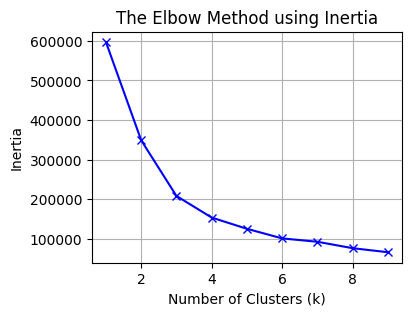

In [ ]:
from scipy.spatial.distance import cdist

# Source: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
def plot_elbow(df, max_clusters, plot_distortions=False, plot_inertia=False):
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    K = range(1, max_clusters)

    for k in K:
        kmeans = KMeans(n_clusters=k, init="k-means++", random_state=RNG_SEED)
        kmeans.fit(df)

        # Calculate distortion as the average squared distance from points to their cluster centers
        distortions.append(sum(np.min(cdist(df, kmeans.cluster_centers_, 'euclidean'), axis=1)**2) / X.shape[0])

        # Inertia is calculated directly by KMeans
        inertias.append(kmeans.inertia_)

        # Store the mappings for easy access
        mapping1[k] = distortions[-1]
        mapping2[k] = inertias[-1]

    if plot_distortions:
        #print("Distortion values:")
        #for key, val in mapping1.items():
        #    print(f'{key} : {val}')
        # Plotting the graph of k versus Distortion
        plt.figure(figsize=(4,3))
        plt.plot(K, distortions, 'bx-')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Distortion')
        plt.title('The Elbow Method using Distortion')
        plt.grid()
        plt.show()

    if plot_inertia:
        #print("Inertia values:")
        #for key, val in mapping2.items():
        #    print(f'{key} : {val}')
        # Plotting the graph of k versus Inertia
        plt.figure(figsize=(4,3))
        plt.plot(K, inertias, 'bx-')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.title('The Elbow Method using Inertia')
        plt.grid()
        plt.show()

plot_elbow(X, 10, plot_inertia=True)

L'elbow plot mostra il numero ideale dei cluster al di sopra del quale l'efficienza inizia a diminuire, rendendo invano l'uso di un numero troppo elevato.<br>
Il plot suggerisce K = 3, valore dopo il quale la curva inizia ad essere meno ripida, implicando che un numero maggiore di cluster non andrebbe a migliorare di molto il clustering dei sample.

In [ ]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=RNG_SEED)
clusters = kmeans.fit_predict(X)

In [ ]:
cluster_distances = pd.DataFrame(cdist(X, kmeans.cluster_centers_, 'euclidean'), columns=[f"Cluster_{i+1}" for i in range(n_clusters)])

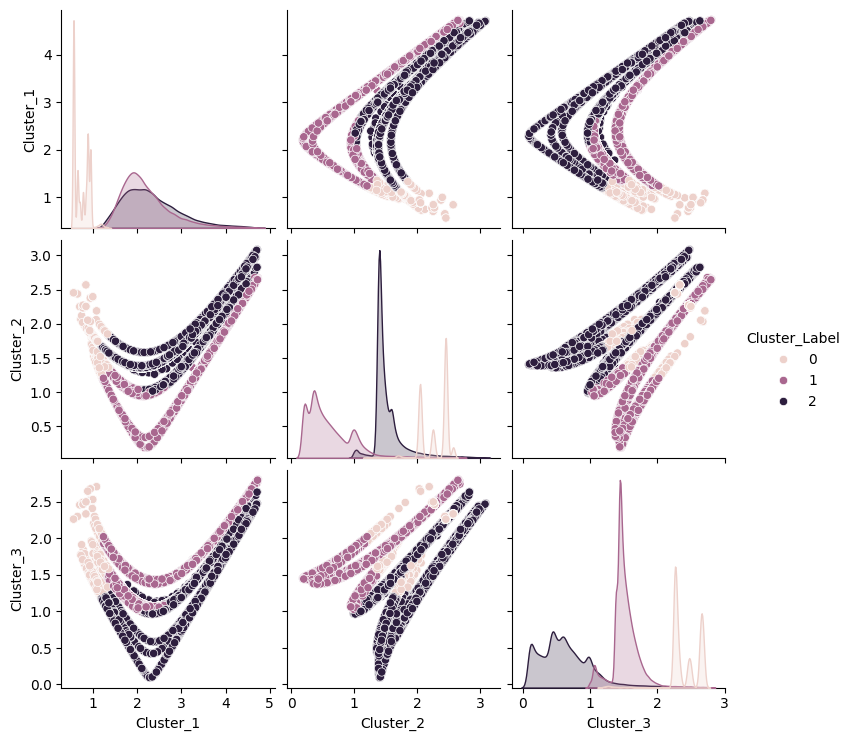

In [ ]:
cluster_distances['Cluster_Label'] = kmeans.labels_
sns.pairplot(cluster_distances, hue='Cluster_Label')
plt.show()

Il plot soprastante mostra le varie distribuzioni delle distanze euclidee di ogni singolo sample rispetto ai vari cluster.<br>
L'origine di ogni plot coincide con il centroide del cluster.<br>
<br>
Sulla diagonale principale si vedono dei spike. Questi spike sono dovuti ad un elevato numero di sample con distanze identiche/simili.<br>
<br>
In sostanza, il KMeans ha trasformato i nostri dati in un qualcosa di più lineare. Ogni sample ha una distanza relativa al centroide, che a sua volta è relativa anche ad altri sample. Questo fattore può favorire un miglioramento delle prestazioni di modelli lineari come la LogisticRegression.

Plottiamo anche i cluster delle varie feature..

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


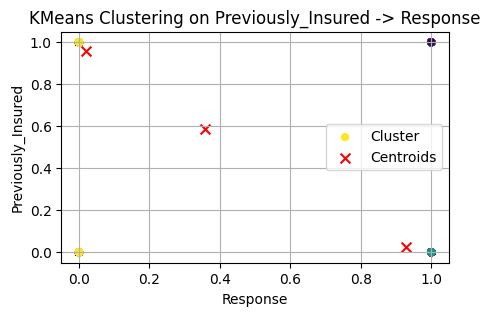

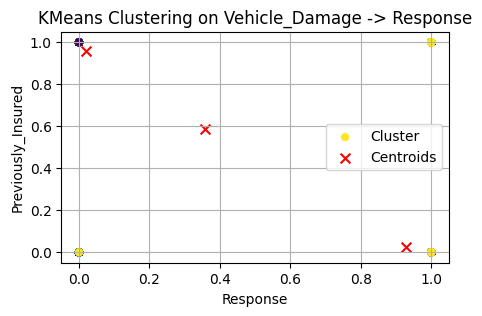

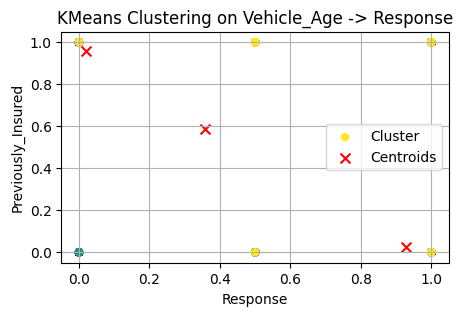

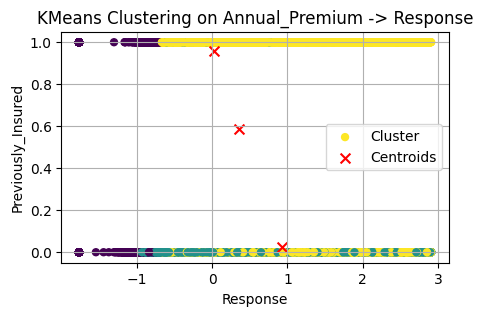

In [ ]:
centroids = kmeans.cluster_centers_

for feat in features:
    if feat == "Response":
        continue

    plt.figure(figsize=(5,3))
    plt.scatter(
        X[feat], y,
        s=25, marker="o", c=clusters,
        label=f'Cluster'
    )

    plt.scatter(
        centroids[:, 0], centroids[:, 1],
        s=50, marker='x', c='red', label='Centroids'
    )

    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.title(f"KMeans Clustering on {feat} -> Response")
    plt.show()

I plot risultano lievemente difficili da interpretare avendo moltissimi sample che si sovrappongono per via del preprocessing che abbiamo fatto, andando a generare dei valori in range simili per tutte le feature.. Rendendone l'analisi visiva meno efficiente.

In ogni caso vediamo che alcuni cluster sono perfettamente sovrapposti/centrati su un set di feature.

# Modello finale
Include l'undersampling, oversampling con SMOTE, preprocessing dei dati, feature engineering sulla base delle distanze rispetto a KMeans Clusters.

In [ ]:
def plot_feat_importance(df, lr):
    feature_importance = pd.DataFrame({'feature': df.columns, 'importance': lr.coef_[0]})
    feature_importance = feature_importance.sort_values('importance', ascending=True)

    plt.figure(figsize=(5, 3))
    sns.barplot(x='importance', y='feature', data=feature_importance, palette="coolwarm", legend=False, hue="feature")
    plt.axvline(0, color='black', linewidth=1)
    plt.xlabel("Coefficient Value (Impact on Prediction)")
    plt.ylabel("Feature")
    plt.title("Feature Importance in Logistic Regression")
    plt.show()

In [ ]:
def clustered_logistic_cross_validation(X, y, k_clusters, weights, plot_metrics_=True, plot_matrix_=True, plot_pr_curve_=True, plot_feat_importance_=True, c_=1.0, undersample_strategy=None, oversample_strategy=None):
    kfold = KFold(n_splits=5, shuffle=True, random_state=RNG_SEED)
    lr = LogisticRegression(class_weight=weights,
                            penalty="l1", solver="saga",
                            #penalty="elasticnet", solver="saga", l1_ratio=0.75,
                            C=c_,
                            max_iter=10000, random_state=RNG_SEED)
    kmeans = KMeans(n_clusters=k_clusters, init="k-means++", random_state=RNG_SEED)

    scores = {
        "accuracy": [],
        "recall": [],
        "precision": [],
        "f1": []
    }

    y_predicted_probabilities = []

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, X_test, y_train, y_test = preprocess_data(X.columns, X_train, X_test, y_train, y_test)

        if undersample_strategy is not None:
            under_sampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=RNG_SEED)
            X_train, y_train = under_sampler.fit_resample(X_train, y_train)
            #X_test, y_test = under_sampler.fit_resample(X_test, y_test)

        if oversample_strategy is not None:
            smote = SMOTE(sampling_strategy=oversample_strategy, k_neighbors=5, random_state=RNG_SEED)
            X_train, y_train = smote.fit_resample(X_train, y_train)
            #X_test, y_test = smote.fit_resample(X_test, y_test)

        # Clustering
        kmeans.fit(X_train)
        clusters_train_distances = pd.DataFrame(cdist(X_train, kmeans.cluster_centers_, metric='euclidean'), index=X_train.index, columns=[f"Cluster_{i+1}" for i in range(k_clusters)])
        clusters_test_distances = pd.DataFrame(cdist(X_test, kmeans.cluster_centers_, metric='euclidean'), index=X_test.index, columns=[f"Cluster_{i+1}" for i in range(k_clusters)])

        # Scale clusters
        scaler = MinMaxScaler()
        clusters_train_distances = pd.DataFrame(scaler.fit_transform(clusters_train_distances), index=clusters_train_distances.index, columns=clusters_train_distances.columns)
        clusters_test_distances = pd.DataFrame(scaler.transform(clusters_test_distances), index=clusters_test_distances.index, columns=clusters_test_distances.columns)

        X_train = pd.concat([X_train, clusters_train_distances], axis=1)
        X_test = pd.concat([X_test, clusters_test_distances], axis=1)

        #X_train = clusters_train_distances
        #X_test = clusters_test_distances

        lr.fit(X_train, y_train)

        print("Train:")
        eval_model(lr, X_train, y_train, plot_metrics=plot_metrics_, plot_matrix=False)

        print("Test:")
        y_pred, y_pred_probs = eval_model(lr, X_test, y_test, plot_metrics=plot_metrics_, plot_matrix=plot_matrix_, plot_pr_curve=plot_pr_curve_)

        if plot_feat_importance_:
            plot_feat_importance(X_test, lr)
        print("-------------------------------")

        y_predicted_probabilities.append((y_test, y_pred, y_pred_probs))

        scores["accuracy"].append(accuracy_score(y_test, y_pred))
        scores["recall"].append(recall_score(y_test, y_pred))
        scores["precision"].append(precision_score(y_test, y_pred))
        scores["f1"].append(f1_score(y_test, y_pred))

    print("Accuracy:", np.mean(scores["accuracy"]))
    print("Recall:", np.mean(scores["recall"]))
    print("Precision:", np.mean(scores["precision"]))
    print("F1-Score:", np.mean(scores["f1"]))

    return y_predicted_probabilities

Train:
              precision    recall  f1-score   support

           0       0.99      0.52      0.68     46095
           1       0.68      1.00      0.81     46095

    accuracy                           0.76     92190
   macro avg       0.83      0.76      0.75     92190
weighted avg       0.83      0.76      0.75     92190

Test:
              precision    recall  f1-score   support

           0       1.00      0.52      0.68     66225
           1       0.23      1.00      0.37      9339

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.58      0.65     75564



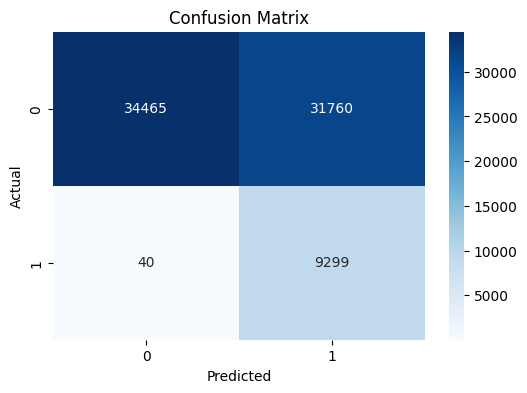

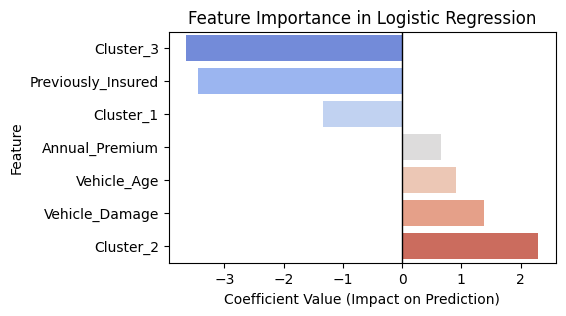

-------------------------------
Train:
              precision    recall  f1-score   support

           0       0.99      0.52      0.68     46232
           1       0.68      1.00      0.80     46232

    accuracy                           0.76     92464
   macro avg       0.83      0.76      0.74     92464
weighted avg       0.83      0.76      0.74     92464

Test:
              precision    recall  f1-score   support

           0       1.00      0.52      0.69     66335
           1       0.23      1.00      0.37      9229

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.58      0.65     75564



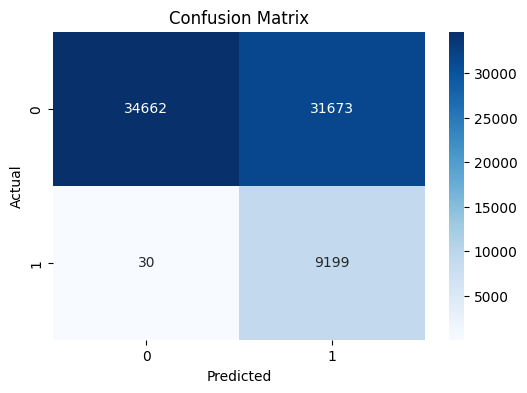

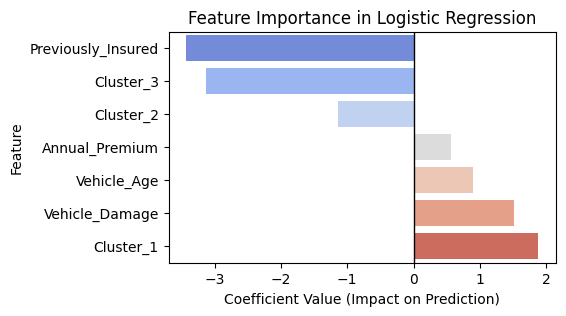

-------------------------------
Train:
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     46361
           1       0.68      1.00      0.81     46361

    accuracy                           0.76     92722
   macro avg       0.84      0.76      0.75     92722
weighted avg       0.84      0.76      0.75     92722

Test:
              precision    recall  f1-score   support

           0       1.00      0.52      0.69     66438
           1       0.22      1.00      0.36      9126

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.52     75564
weighted avg       0.91      0.58      0.65     75564



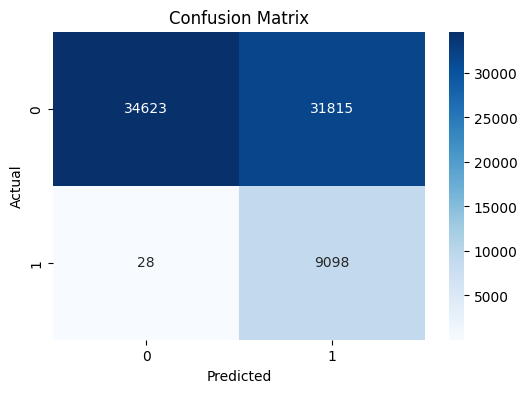

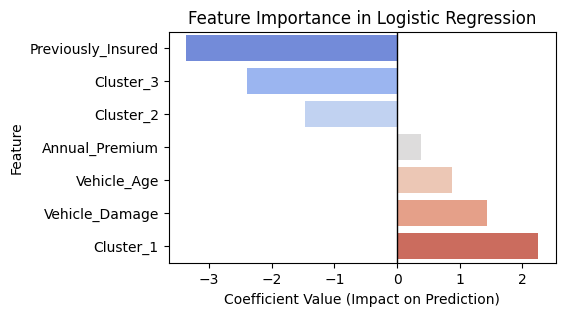

-------------------------------
Train:
              precision    recall  f1-score   support

           0       0.99      0.52      0.69     46202
           1       0.68      1.00      0.81     46202

    accuracy                           0.76     92404
   macro avg       0.83      0.76      0.75     92404
weighted avg       0.83      0.76      0.75     92404

Test:
              precision    recall  f1-score   support

           0       1.00      0.53      0.69     66311
           1       0.23      1.00      0.37      9253

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.58      0.65     75564



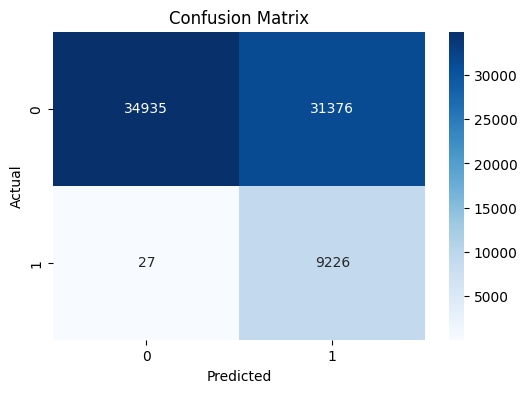

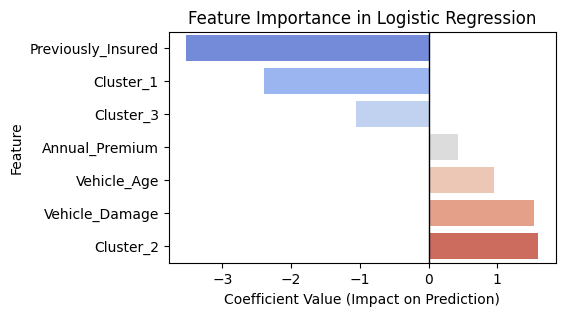

-------------------------------
Train:
              precision    recall  f1-score   support

           0       0.99      0.52      0.68     46183
           1       0.68      1.00      0.81     46183

    accuracy                           0.76     92366
   macro avg       0.83      0.76      0.75     92366
weighted avg       0.83      0.76      0.75     92366

Test:
              precision    recall  f1-score   support

           0       1.00      0.52      0.68     66296
           1       0.22      1.00      0.37      9268

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.52     75564
weighted avg       0.90      0.58      0.64     75564



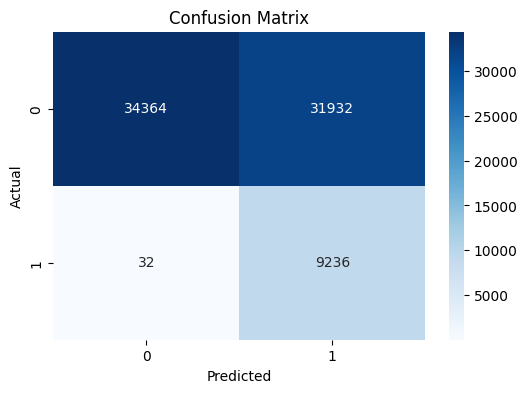

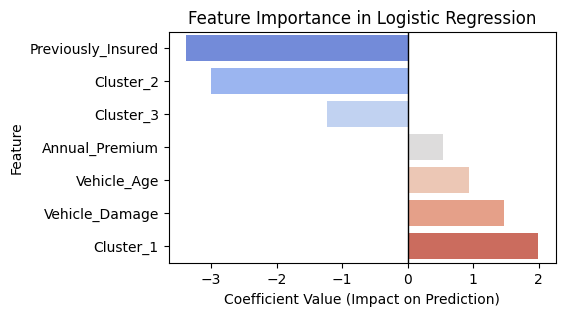

-------------------------------
Accuracy: 0.5799243025779472
Recall: 0.9966054786127106
Precision: 0.22510019538888684
F1-Score: 0.36724736474657815


In [ ]:
#features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Gender", "Age", "Policy_Sales_Channel", "Vintage", "Annual_Premium"]
#features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Policy_Sales_Channel", "Age", "Gender", "Annual_Premium"]
#features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Age", "Annual_Premium"]
#features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Vintage", "Annual_Premium"]
#features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Age"]
#features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Policy_Sales_Channel"]
features = ["Response", "Previously_Insured", "Vehicle_Damage", "Vehicle_Age", "Annual_Premium"] # Feature scelte nel modello 3

X, y = select_features(df_raw, features)

y_predicted_probs_4 = clustered_logistic_cross_validation(X, y, k_clusters=3, weights={0: 1, 1: 6}, plot_metrics_=True, plot_pr_curve_=False, plot_feat_importance_=True, undersample_strategy=0.8, oversample_strategy=1.0)

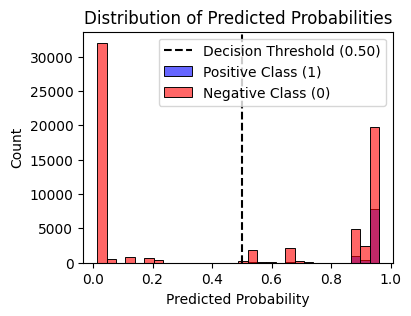

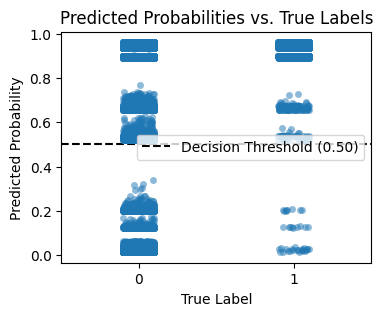

-----------------------------


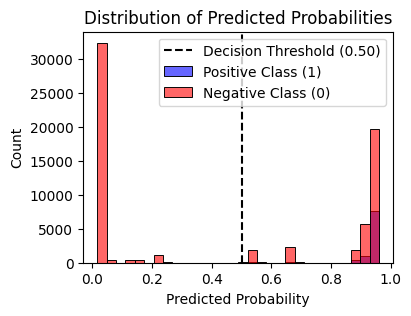

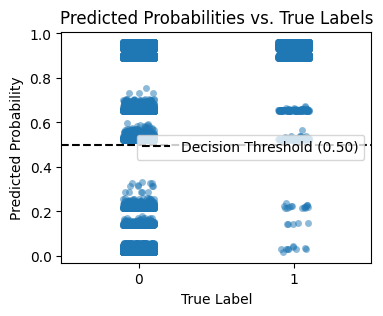

-----------------------------


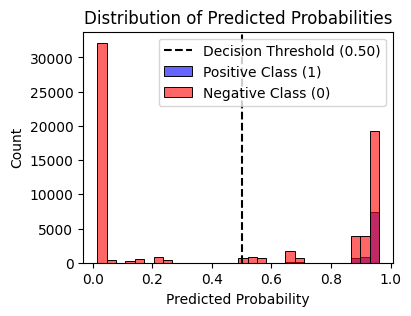

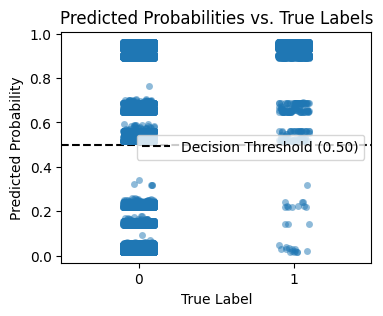

-----------------------------


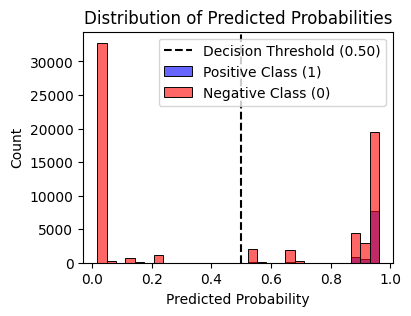

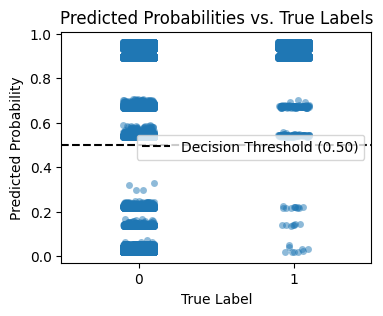

-----------------------------


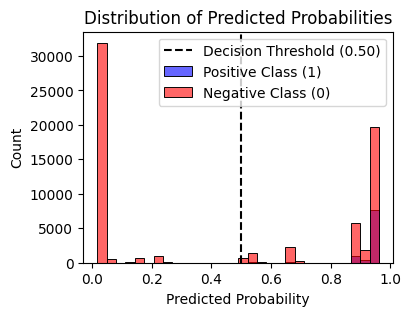

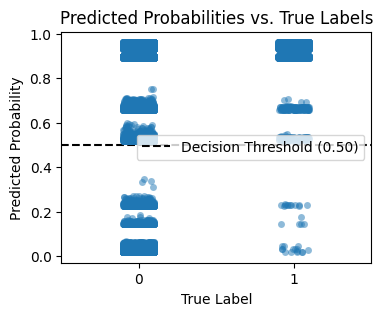

-----------------------------


In [ ]:
decision_threshold = 0.5

for y_test, y_pred, y_pred_probs in y_predicted_probs_4:
    plot_prob_dist(y_pred_probs[:, 1], decision_threshold)
    plot_label_probs(y_test, y_pred_probs[:, 1], decision_threshold)
    print("-----------------------------")

In [ ]:
print_pred_metrics(y_predicted_probs_4)

Threshold: 0.10
Accuracy: 0.5543353978084803
Recall: 0.9984656920806803
Precision: 0.21517372167612545
F1-Score: 0.3540449923857462
--------------------------------
Threshold: 0.20
Accuracy: 0.5651606585146366
Recall: 0.9978182356442042
Precision: 0.2192774798947233
F1-Score: 0.35953878531348227
--------------------------------
Threshold: 0.30
Accuracy: 0.579860780265735
Recall: 0.9966273940192412
Precision: 0.22507653885217027
F1-Score: 0.36721734762818936
--------------------------------
Threshold: 0.40
Accuracy: 0.5799243025779472
Recall: 0.9966054786127106
Precision: 0.22510019538888684
F1-Score: 0.36724736474657815
--------------------------------
Threshold: 0.50
Accuracy: 0.5799243025779472
Recall: 0.9966054786127106
Precision: 0.22510019538888684
F1-Score: 0.36724736474657815
--------------------------------
Threshold: 0.60
Accuracy: 0.6078264782171404
Recall: 0.9889634558163763
Precision: 0.23636825452583649
F1-Score: 0.38154187080056245
--------------------------------
Thresho

Il range tra 0.30 - 0.40 sembra essere il miglior compromesso.

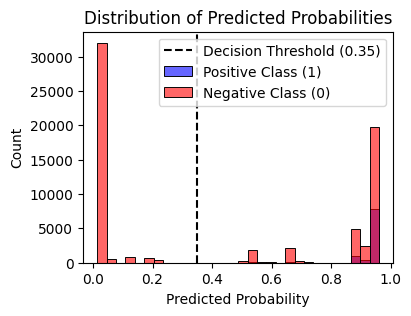

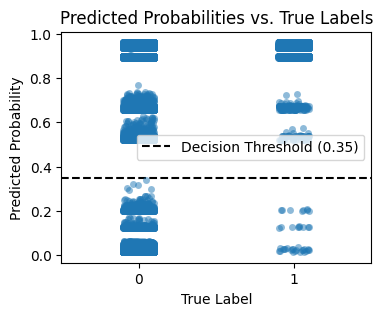

-----------------------------


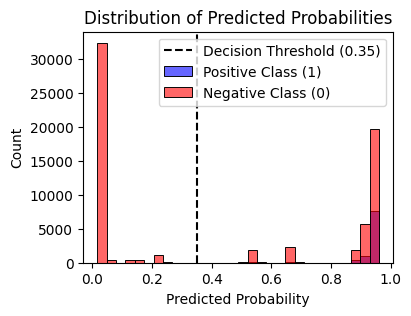

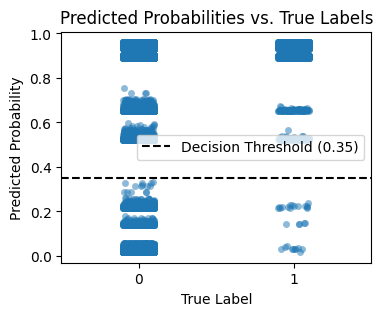

-----------------------------


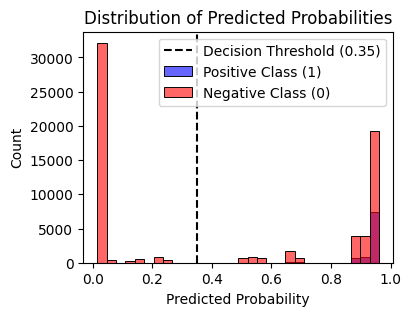

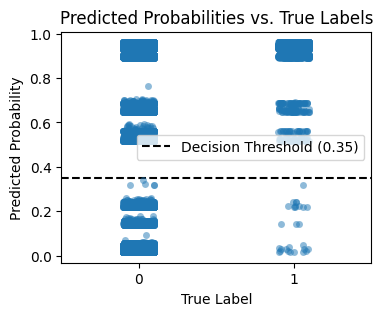

-----------------------------


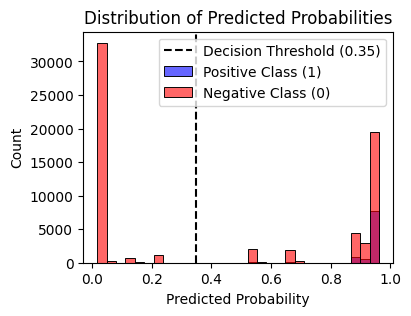

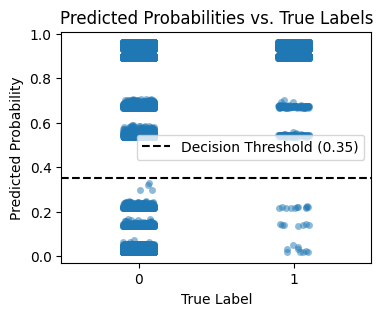

-----------------------------


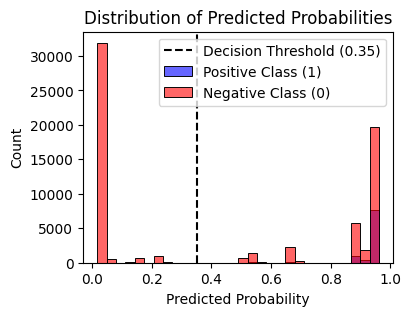

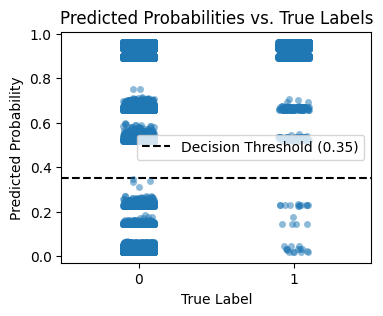

-----------------------------


In [ ]:
decision_threshold = 0.35

for y_test, y_pred, y_pred_probs in y_predicted_probs_4:
    plot_prob_dist(y_pred_probs[:, 1], decision_threshold)
    plot_label_probs(y_test, y_pred_probs[:, 1], decision_threshold)
    print("-----------------------------")

In [ ]:
print_pred_metrics_with_threshold(y_predicted_probs_4, decision_threshold)

Threshold: 0.35
Accuracy: 0.5799243025779472
Recall: 0.9966054786127106
Precision: 0.22510019538888684
F1-Score: 0.36724736474657815
--------------------------------


In [ ]:
for y_test, y_pred, y_pred_probs in y_predicted_probs_4:
    pred_probs = y_pred_probs[:, 1]
    y_pred_masked = (pred_probs >= decision_threshold).astype(int)

    print(classification_report(y_test, y_pred_masked))
    print("--------------------------------")

              precision    recall  f1-score   support

           0       1.00      0.52      0.68     66225
           1       0.23      1.00      0.37      9339

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.58      0.65     75564

--------------------------------
              precision    recall  f1-score   support

           0       1.00      0.52      0.69     66335
           1       0.23      1.00      0.37      9229

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.53     75564
weighted avg       0.90      0.58      0.65     75564

--------------------------------
              precision    recall  f1-score   support

           0       1.00      0.52      0.69     66438
           1       0.22      1.00      0.36      9126

    accuracy                           0.58     75564
   macro avg       0.61      0.76      0.52     75564
weighted

Anche se il clustering ha reso le feature più lineari, non ha portato ad un miglioramento delle metriche. Infatti sono rimaste invariate. Le class_weights sono rimaste a 1:6 ed il threshold è stato ridotto a 0.35 per arrivare alla stessa performance.

```
Modello 3

Threshold: 0.50
Accuracy: 0.5799243025779472
Recall: 0.9966054786127106
Precision: 0.22510019538888684
F1-Score: 0.36724736474657815
```

```
Modello 3.1

Threshold: 0.50
Accuracy: 0.5799243025779472
Recall: 0.9966054786127106
Precision: 0.22510019538888684
F1-Score: 0.36724736474657815
```

```
Modello finale

Threshold: 0.35
Accuracy: 0.5799243025779472
Recall: 0.9966054786127106
Precision: 0.22510019538888684
F1-Score: 0.36724736474657815
```

Piccola osservazione relativa alla precision: La precision indica di fatto la precisione del modello rispetto ad una classe, ma varia in funzione del recall. Un recall più alto farà diminuire la precision perchè va ad aumentare i false positives. Quindi, classificando erroneamente la classe opposta, la precisione scende. Con qualche tecnica più mirata avremmo potuto migliorarla mantenendo comunque un recall elevato. Ma per raggiungere ciò bisognerebbe elaborare il dataset ulteriormente, generando nuove feature e/o passare ad un classificatore più complesso.

# Conclusione
Abbiamo esplorato diverse tecniche al fine di migliorare la regressione logistica, partendo da un dataset molto sbilanciato e con dati rumorosi.<br>
<br>
Le diverse tecniche applicate hanno migliorato il classificatore in modo tale da ridurre il parametro "class weight", che penalizza la classificazione errata di una classe rispetto all'altra.<br>
<br>
L'elaborazione del dataset ha reso possibile equilibrare i sample a disposizioni per addestrare il modello, il che si è rivelato essere sufficiente per massimizzare la performance della LogisticRegression.<br>
<br>
Infatti, anche il Clustering, tecnica che permette di categorizzare i sample a dei cluster e quindi renderli più "lineari", usata per creare nuove feature da integrare nel dataset non ha apportato alcun miglioramento in questo caso specifico.<br>
<br>
Il focus delle metriche era quello di massimizzare la capacità di classificare quanti più sample appartenenti alla classe positiva, così da non perdere potenziali clienti a cui proporre la polizza assicurativa.<br>
Qualche cliente sfugge comunque al nostro classificatore, ma allo stesso tempo genera parecchi falsi positivi (ma pochissimi falsi negativi), quindi bisogna trovare un compromesso al fine di non destabilizzarlo troppo e di non aumentare in maniera sproporzionata le classificazioni errate.<br>
<br>
Per questo progetto è stata presa la decisione di limitarsi al solo uso della LogisticRegression come classificatore binario, senza esplorare altri classificatori quali SVM, XGBoost, DecisionTrees, ecc, modelli che potrebbero essere molto più efficaci rispetto alla LogisticRegression (ma che fanno parte del prossimo modulo :)<br>
<br>
In conclusione definitiva, le techniche applicate al "Modello di previsione 3" furono sufficienti per arrivare ad un modello utilizzabile. Ciò non toglie il fatto che anche il clustering potrebbe aiutare a rendere la classificazione molto più stabile di fronte a dataset con outlier pesanti.